# INTRODUCTION

## Overview

King County is located in the U.S. state of Washington. The population was 2,252,782 in the 2019 census estimate, making it the most populous county in Washington, and the 12th-most populous in the United States. The county seat is Seattle, also the state's most populous city. The county is named to honor civil rights leader Martin Luther King Jr.[[1]](https://en.wikipedia.org/wiki/King_County,_Washington) 

The county sees a USD 700K Median Listing Home Price, USD 431 Median Listing Home Price/Sq Ft, USD 766K Median Sold Home Price, with around 6000 homes listed for sale and 2800 homes for rent.[[2]](https://www.realtor.com/realestateandhomes-search/King-County_WA/overview) Homes in King County, WA sold for 2.19% above asking price on average in March 2021 with a median of 36 days days on market.


In March 2021, King County home prices were up 15.4% compared to last year. There were 3,198 homes sold in March 2021, up from 2,656 last year.[[3]](https://www.redfin.com/county/118/WA/King-County/housing-market).

This makes the county a prime market of real estate, and a paramount candidate for analysis. The namesake of Martin King Luther Jr. has a very lucrative real estate market worth exploring.

## Business problem

<img src="./assets/image_1.gif"
     alt="Map!"
     style="float: center; margin-center: 2px;">
     
Source: image generated by author using tableau public, and online gif maker.

King County Residents that want to renovate their home to increase its resale value, but don't know what factors are important for determining a home's value. While focusing on features they can renovate, I shall discuss key factors of a home's price. This factors can be both under their constrain and beyond their control.

Those include:
- How to improve marketability.
- Focus on which aspect of the house.
- What factors to keep in mind deciding budget and required return on investment.

# The imports

## Packages

In [2]:
# core operational packeges
import os
import warnings
# data manupulation
import pandas as pd
pd.set_option('display.max_columns',0)
import numpy as np

# plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

# Statistics
import statistics as stat
import scipy.stats as stats

# regression
## statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols

## scikit-learn
from sklearn import metrics
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV


# notebook styling packages
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks='True', grid='False')
## to reset to default theme
# jtplot.reset() 

## Functions used

### Exploration

In [3]:
def check_NaN(df):
    """
    Checks for NaN in the pandas DataFrame and spits a DataFrame of report.
    Uses df.isnull() method.
    
    Parameters:
    ===========
    df = pandas.DataFrame
    """
    null_checking = []
    for column in df.columns:
        not_null = df[column].isnull().value_counts()[0]
        try:
            is_null = df[column].isnull().value_counts()[1]
        except:
            is_null = 0
        temp_dict = {'name': column, 'is_null': is_null, 'not_null': not_null}
        null_checking.append(temp_dict)
    df_ = pd.DataFrame(null_checking)
    return df_

In [4]:
def check_duplicates(df):
    """
    Checks for duplicates in the pandas DataFrame and splits a Dataframe of report.
    
    Parameters:
    ===========
    df = pandas.DataFrame
    """
    dup_checking = []
    for column in df.columns:
        not_duplicated = df[column].duplicated().value_counts()[0]
        try:
            duplicated = df[column].duplicated().value_counts()[1]
        except:
            duplicated = 0
        temp_dict = {
            'name': column,
            'duplicated': duplicated,
            'not_duplicated': not_duplicated
        }
        dup_checking.append(temp_dict)
    df_ = pd.DataFrame(dup_checking)
    return df_

In [5]:
def correlation_top_bottom(df):
    """
    Input a Pandas correlation matrix DataFrame (df.corr()) to get top 10 positive and negetively correlated features.
    
    Parameters:
    ===========
    df = pandas.core.frame.DataFrame; use df.corr().
    """
    corr_df_matrix_ = df.unstack().reset_index()
    corr_df_matrix_.columns = ["feature_0", 'feature_1', 'correlation']
    corr_df_matrix_['keep'] = corr_df_matrix_.apply(
        lambda x: False if x['feature_0'] == x['feature_1'] else True, axis=1)
    corr_df_matrix_['feature_combo'] = corr_df_matrix_.apply(
        lambda x: ' and '.join(set(x[['feature_0', 'feature_1']])), axis=1)
    corr_featurs = corr_df_matrix_[corr_df_matrix_.keep][[
        'feature_combo', 'correlation'
    ]].drop_duplicates().sort_values(by='correlation', ascending=False)
    print(
        f'Positive correlations:\n{corr_featurs.head(10).reset_index()}\n\n{"-"*70}\nNegative correlations:\n{corr_featurs.sort_values(by="correlation").head(10).reset_index()}'
    )

In [6]:
def format_number(data_value, index):
    """
    +++ formatting helper function +++
    __________________________________
    Formats values to thousands, millions and billions.
    Used for modifying chart axes.
    """
    if data_value >= 1_000_000_000:
        formatter = '${:1.1f}B'.format(data_value * 0.000_000_001)
    elif data_value >= 1_000_000:
        formatter = '${:1.0f}M'.format(data_value * 0.000_001)
    else:
        formatter = '${:1.0f}K'.format(data_value * 0.001)
    return formatter

In [7]:
def feature_prob_details(x, alpha=.05):
    """
    Displays:
    =========
    Plots boxplot, density plot, cdf and probability plot with fitting of given data.
    Decison based on both:
    Shapiro-Wilk Test and Kolmogorov-Smirnov test for goodness of fit at 95% confidence interval.
    
    Parameters:
    ===========
    x = array OR DataFrame Series Object; target data
    alpha = float; default: .05
    
    Note:
    =====
    For Kolmogorov-Smirnov it uses two sided test. To change this modify source code.
    """
    plt.close('all')
    fig = plt.figure(figsize=(14, 6))

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (0, 2))
    ax3 = plt.subplot2grid((3, 3), (1, 0), colspan=2, rowspan=2)
    ax4 = plt.subplot2grid((3, 3), (1, 2), rowspan=2)
    # ax1
    sns.boxplot(x=x, ax=ax1,
                color='gold')  #.xaxis.set_major_formatter(format_number)
    ax1.set_title('Box and Whiskers Plot')
    # ax2
    sns.kdeplot(x,
                color='gold',
                label='kde',
                palette="pastel",
                cumulative=True,
                ax=ax2)
    ax2.set_title('CDF')
    # ax3
    sns.histplot(x,
                 bins=20,
                 alpha=.5,
                 color='silver',
                 stat="density",
                 fill=True,
                 label='hist',
                 palette="pastel",
                 element='step',
                 ax=ax3)#.xaxis.set_major_formatter(format_number)
    sns.kdeplot(x, color='gold', label='kde', palette="pastel", ax=ax3)
    ax3.set_title('Density Estimation')
    ax3.legend()
    # ax4
    sm.graphics.qqplot(x,
                       fit=True,
                       line='r',
                       marker='h',
                       markerfacecolor='silver',
                       alpha=0.5,
                       ax=ax4)
    sm.qqline(line='45', fmt='g--', lw=1, alpha=.8, ax=ax4)
    ax4.set_title('Probability Plot')
    plt.suptitle(t=f'Probability details of "{x.name}" feature',
                 size=20,
                 weight=14)
    plt.tight_layout()
    plt.show()
    
    from scipy.stats import shapiro
    from scipy.stats import kstest
    t_stat, p_val = shapiro(x)
    t_stat1, p_val1 = kstest(x, stats.norm.cdf)
    alpha = alpha
    if (p_val or p_val1) < alpha:
        print(
            f'Distribution is NOT NORMAL based on Shapiro-Wilk Test and Kolmogorov-Smirnov test for goodness of fit at {(1-alpha)*100}% confidence interval.'
        )
    else:
        print(
            f'Distribution IS NORMAL based on Shapiro-Wilk Test and Kolmogorov-Smirnov test for goodness of fit at {(1-alpha)*100}% confidence interval.'
        )

In [8]:
def silencer():
    # warnings husher
    """
    Silences user warning
    +++ formatting helper function +++
    """
    warnings.simplefilter("ignore")
    warnings.warn("UserWarning", UserWarning)

In [9]:
def heatmap_DataFrame(df, annot_format='.1f'):
    """
    Return a masked heatmap of the given DataFrame
    
    Parameters:
    ===========
    df            = pandas.DataFrame object.
    annot_format  = str, for formatting; default: '.1f'
        
    Example `annot_format`:
    -----------------------
    .1e = scientific notation with 1 decimal point (standard form)
    .2f = 2 decimal places
    .3g = 3 significant figures
    .4% = percentage with 4 decimal places
    
    Note:
    =====
    Rounding error can happen if '.1f' is used.
    
    -- version: 1.1 --
    """
    with plt.style.context('dark_background'):
        plt.figure(figsize=(10, 10), facecolor='k')
        mask = np.triu(np.ones_like(df.corr(), dtype=bool))
        cmap = sns.diverging_palette(3, 3, as_cmap=True)
        sns.heatmap(df.corr(),
                    mask=mask,
                    cmap=cmap,
                    annot=True,
                    fmt=annot_format,
                    linecolor='k',
                    annot_kws={"size": 9},
                    square=True,
                    linewidths=.5,
                    cbar_kws={"shrink": .5})
        plt.title(f'Features heatmap', fontdict={"size": 20})

In [10]:
def top_correlated_features(df, limit=.75, verbose=False):
    """
    Input a Pandas DataFrame to get top correlated (based on absolute value) features filtered by a cutoff.
    
    Parameters:
    ===========
    df        = pandas.DataFrame object.
    limit     = float; default: .75
    verbose   = boolean; default: False. 
        `True` returns DataFrame without filtering by cutoff.
        `False` returns DataFrame filted by cutoff.
    """
    df_corr = df.corr().abs().unstack().reset_index().sort_values(
        0, ascending=False)
    df_corr.columns = ["feature_0", 'feature_1', 'correlation']
    df_corr['keep_me'] = df_corr.apply(
        lambda x: False if x['feature_0'] == x['feature_1'] else True, axis=1)
    df_corr['feature_combo'] = df_corr.apply(
        lambda x: ' and '.join(set(x[['feature_0', 'feature_1']])), axis=1)

    corr_features = df_corr[df_corr.keep_me == True][[
        'feature_combo', 'correlation'
    ]].drop_duplicates().reset_index(drop='index')
    # features with correlation more than 75%
    if verbose == True:
        return corr_features
    else:
        return corr_features[corr_features.correlation > limit]

In [11]:
def check_for_high_p_val(input_, thresh_hold=.05, sorted_=False):
    """
    Input a statsmodels.regression.linear_model.RegressionResultsWrapper to get features abobe a thresh hold.
        
    Parameters:
    ===========
    input_      = statsmodels.regression.linear_model.RegressionResultsWrapper
    thresh_hold = float; default: .05.
    """
    x = input_.pvalues[input_.pvalues > thresh_hold].to_frame().reset_index()
    x.columns = ['features', 'p_values']

    if sorted_:
        return x.sort_values(
            by='p_values',
            ascending=False).style.set_precision(4).set_properties(
                **{
                    'background': 'black',
                    'color': 'lawngreen'
                })
    else:
        return x.style.set_precision(4).set_properties(**{
            'background': 'black',
            'color': 'lawngreen'
        }).background_gradient('Reds')

In [12]:
def num_col_for_plotting(row, col=3):
    """
    +++ formatting helper function +++
    __________________________________
    Returns number of rows to plot
    
    Parameters:
    ===========
    row = int;
    col = int; default col: 3
    """
    if row % col != 0:
        return (row // col) + 1
    else:
        return row // col

In [13]:
def test_for_linearity(df, target='price'):
    """
    Test for the linearity assumption among features
    
    Parameters:
    ===========
    df      = pandas.Dataframe object
    target  = str; default target: 'price'
    """
    fig, axes = plt.subplots(nrows=num_col_for_plotting(
        len(df.drop(target, axis=1).columns)),
                             ncols=3,
                             figsize=(16, 25),
                             sharey=True)

    for ax, column in zip(axes.flatten(), df.drop(target, axis=1).columns):
        sns.scatterplot(x=df[column],
                        y=df['price'],# / 100_000,
                        markers='H',
                        palette="pastel",
                        color='silver',
                        alpha=.5,
                        ax=ax)
        ax.set_title(f'{target.title()} vs {column.title()}')
        sns.despine()
        plt.tight_layout()

    plt.suptitle(y=1,
                 t='Test for the linearity assumption',
                 va='bottom',
                 size=20,
                 weight=14)
    plt.show()

In [14]:
def find_outliers_Z(data):
    """
    ### Study Group function -- not reinventing the wheel ###
    Link:
    __________________________________________________________
    Use scipy to calculate absolute Z-scores 
    and return boolean series where True indicates it is an outlier.

    Args:
        data (Series,or ndarray): data to test for outliers.

    Returns:
        [boolean Series]: A True/False for each row use to slice outliers.
        
    EXAMPLE USE: 
    >> idx_outs = find_outliers_df(df['AdjustedCompensation'])
    >> good_data = df[~idx_outs].copy()
    """
    ## Calculate z-scores
    zs = stats.zscore(data)
    
    ## Find z-scores >3 awayfrom mean
    idx_outs = np.abs(zs)>3
    
    ## If input was a series, make idx_outs index match
    if isinstance(data,pd.Series):
        return pd.Series(idx_outs,index=data.index)
    else:
        return pd.Series(idx_outs)

In [15]:
def find_outliers_IQR(data):
    """
    ### Study Group function -- not reinventing the wheel ###
    Link:
    __________________________________________________________
    Use Tukey's Method of outlier removal AKA InterQuartile-Range Rule
    and return boolean series where True indicates it is an outlier.
    - Calculates the range between the 75% and 25% quartiles
    - Outliers fall outside upper and lower limits, using a treshold of  1.5*IQR the 75% and 25% quartiles.

    IQR Range Calculation:    
        res = df.describe()
        IQR = res['75%'] -  res['25%']
        lower_limit = res['25%'] - 1.5*IQR
        upper_limit = res['75%'] + 1.5*IQR

    Args:
        data (Series,or ndarray): data to test for outliers.

    Returns:
        [boolean Series]: A True/False for each row use to slice outliers.
        
    EXAMPLE USE: 
    >> idx_outs = find_outliers_df(df['AdjustedCompensation'])
    >> good_data = df[~idx_outs].copy()
    
    """
    df_b=data
    res= df_b.describe()

    IQR = res['75%'] -  res['25%']
    lower_limit = res['25%'] - 1.5*IQR
    upper_limit = res['75%'] + 1.5*IQR

    idx_outs = (df_b>upper_limit) | (df_b<lower_limit)

    return idx_outs

In [16]:
def check_outliers_in_df(df,
                         chart_type='boxplot',
                         show_dfs=True,
                         turn_off_boxplot=False):
    """
    Returns value counts of the DataFrame columns and a boxplot or boxenplot.
    Use:
        Check for outliers in the dataset.
        
    Parameters:
    ===========
    df                = pandas.DataFrame object.
    chart_type        = str: either 'boxplot' or 'boxenplot'
    turn_off_boxplot  = boolean; default: False.
        `True` shows plot.
        `False`  does not plot.
    """
    if show_dfs:
        print('DataFrame Columns value counts.')
        for column in df:
            print(f"{'_'*60}")
            print(
                f'{column}: ({df[column].nunique(dropna=False)} unique values including NaN)'
            )
            print(df[column].value_counts(dropna=False))
            print(f"{'_'*60}")

    if turn_off_boxplot == False:
        print('')
        print(f"{'_'*60}")
        print(f'DataFrame Columns {chart_type.title()}')
        print(f"{'_'*60}")

        # default col for chart is 3, to be able to single or 2 features
        # this cells are used
        n = 3
        w = 16
        h = 25
        if len(df.columns) < n:
            n = len(df.columns)
            w = 8
            h = 5
        if len(df.columns) == 1:
            if chart_type == 'boxplot':
                sns.boxplot(x=df.columns[0], data=df, color='gold')
            if chart_type == 'boxenplot':
                sns.boxenplot(x=df.columns[0], data=df, color='gold')
            sns.despine()
            plt.tight_layout()
        # for features more than 2
        else:
            fig, axes = plt.subplots(nrows=num_col_for_plotting(len(
                df.columns),
                                                                col=n),
                                     ncols=n,
                                     figsize=(w, h),
                                     sharey=True)
            for ax, column in zip(axes.flatten(), df):
                if chart_type == 'boxplot':
                    sns.boxplot(x=column, data=df, color='gold', ax=ax)
                if chart_type == 'boxenplot':
                    sns.boxenplot(x=column, data=df, color='gold', ax=ax)
                ax.set_title(
                    f'{chart_type.title()} of distribution of {column.title()}'
                )
                sns.despine()
                plt.tight_layout()

In [17]:
def Distance(lat1, lons1, lat2, lons2):
    """
    Calculates distance in kilometere between two places given lattitude and longitude with consideration of earths curvature.
    
    Parameters:
    ===========
    lat1  = float or int. coordinate of location 1.  
    lons1 = float or int. coordinate of location 1.
    lat2  = float or int. coordinate of location 2. 
    lons2 = float or int. coordinate of location 2. 
    
    Source:
    https://stackoverflow.com/questions/27928/calculate-distance-between-two-latitude-longitude-points-haversine-formula
    """
    import math
    a = 6378.137  #equitorial radius in km
    b = 6356.752  #polar radius in km
    lat1 = math.radians(lat1)
    lons1 = math.radians(lons1)
    R = (((((a**2) * math.cos(lat1))**2) + (((b**2) * math.sin(lat1))**2)) /
         ((a * math.cos(lat1))**2 +
          (b * math.sin(lat1))**2))**0.5  #radius of earth at lat1
    x1 = R * math.cos(lat1) * math.cos(lons1)
    y1 = R * math.cos(lat1) * math.sin(lons1)
    z1 = R * math.sin(lat1)

    lat2 = math.radians(lat2)
    lons2 = math.radians(lons2)
    R = (((((a**2) * math.cos(lat2))**2) + (((b**2) * math.sin(lat2))**2)) /
         ((a * math.cos(lat2))**2 +
          (b * math.sin(lat2))**2))**0.5  #radius of earth at lat2
    x2 = R * math.cos(lat2) * math.cos(lons2)
    y2 = R * math.cos(lat2) * math.sin(lons2)
    z2 = R * math.sin(lat2)

    return ((x1 - x2)**2 + (y1 - y2)**2 +
            (z1 - z2)**2)**0.5  # * 0.621371 for mile

In [18]:
def distance_(df, lat, long):
    """
    +++ Helper Function +++
    Takes a DataFrame conatining lat and long values and calculates distance in miles (rounded to two decimal place) from Seattle downtown.
    Seattle downtown latitude = 47.6062, longitude = -122.3321
    """
    p = df[lat].to_list()
    k = df[long].to_list()
    temp_list = []
    for x in zip(p, k):
        z = {
            'distance_from_downtown_mile':
            round(Distance(x[0], x[1], 47.6062, -122.3321) * 0.621371, 2)
        }
        temp_list.append(z)
    df_ = pd.DataFrame(temp_list)
    return df_

### Plotly Charts

In [19]:
def get_location_interactive(mapbox_style="open-street-map"):
    """
    +++ Predefined function +++
    Returns a map with markers for houses based on lat and long.
    
    Parameters:
    ===========
    mapbox_style = str; options are following:
        > "white-bg" yields an empty white canvas which results in no external HTTP requests

        > "carto-positron", "carto-darkmatter", "stamen-terrain",
          "stamen-toner" or "stamen-watercolor" yield maps composed of raster tiles 
          from various public tile servers which do not require signups or access tokens

        > "open-street-map" does work
    """
    fig = px.scatter_mapbox(df,
                            lat=df.lat,
                            lon=df.long,color='price',
                            color_continuous_scale=["green",'blue','red','gold'],
                            zoom=8.5,range_color=[0,df['price'].quantile(0.95)],
                            height=700,
                            title='House location',
                            opacity=.5,
                            center={
                                'lat': df.lat.mode()[0],
                                'lon': df.long.mode()[0]
                            })
    fig.update_layout(mapbox_style=mapbox_style)
    fig.update_layout(margin={"r": 0, "l": 0, "b": 0})
    fig.show()

In [20]:
def get_location_static(mapbox_style='stamen-terrain'):
    """
    +++ Predefined function +++
    Returns a map with markers for houses based on lat and long.
    
    Parameters:
    ===========
    mapbox_style = str; options are following:
        > "white-bg" yields an empty white canvas which results in no external HTTP requests
        
        > "carto-positron", "carto-darkmatter", "stamen-terrain",
          "stamen-toner" or "stamen-watercolor" yield maps composed of raster tiles 
          from various public tile servers which do not require signups or access tokens
        
        > "open-street-map" does not work
    """

    fig = px.scatter_mapbox(df,
                            lat=df.lat,
                            lon=df.long,color='price',
                            color_continuous_scale=["green",'blue','red','gold'],
                            zoom=8.5,range_color=[0,df['price'].quantile(0.95)],
                            height=700,
                            title='House location',
                            opacity=.5,
                            center={
                                'lat': df.lat.mode()[0],
                                'lon': df.long.mode()[0]
                            })
    fig.update_layout(mapbox_style=mapbox_style)
    fig.update_layout(margin={"r": 0, "l": 0, "b": 0})
    import plotly.io as plyIo
    img_bytes = fig.to_image(format="png", width=1200, height=700, scale=1)
    from IPython.display import Image
    display(Image(img_bytes))

In [21]:
def average_price_by_zipcode_static(mapbox_style='carto-darkmatter'):
    """
    +++ Predefined function +++
    Returns a map with box based on zipcode for average house prices.
    
    Parameters:
    ===========
    mapbox_style = str; options are following:
        > "white-bg" yields an empty white canvas which results in no external HTTP requests
        
        > "carto-positron", "carto-darkmatter", "stamen-terrain",
          "stamen-toner" or "stamen-watercolor" yield maps composed of raster tiles 
          from various public tile servers which do not require signups or access tokens
        
        > "open-street-map" does not work
    _________________________________________________________________________
    Uses geodata from:
    https://github.com/OpenDataDE/State-zip-code-GeoJSON/blob/master/wa_washington_zip_codes_geo.min.json
    """
    # geodata in form of geojson file
    # retrived from https://github.com/OpenDataDE/State-zip-code-GeoJSON/blob/master/wa_washington_zip_codes_geo.min.json
    washinton_zip = json.load(
        open('./data/wa_washington_zip_codes_geo.min.json', 'r'))
    # extract zipcode for id matching
    for feature in washinton_zip['features']:
        feature['id'] = feature['properties']['ZCTA5CE10']

    fig = px.choropleth_mapbox(
        data_frame=df_mean_price_by_zip,
        locations='zipcode',
        geojson=washinton_zip,
        color='price',
        mapbox_style=mapbox_style,
        zoom=8.5,
        height=800,
        color_continuous_scale=['green', 'blue', 'red', 'gold'],
        title='Zipcode by Average Price',
        labels={'price': 'Average House Price'},
        opacity=.7,
        center={
            'lat': df.lat.mode()[0],
            'lon': df.long.mode()[0]
        })
    fig.update_geos(fitbounds='locations', visible=True)
    fig.update_layout(margin={"r": 0, "l": 0, "b": 0})
    #     fig.show()
    import plotly.io as plyIo
    img_bytes = fig.to_image(format="png", width=1400, height=800, scale=1)
    from IPython.display import Image
    display(Image(img_bytes))

In [22]:
def average_price_by_zipcode_interactive(mapbox_style="carto-darkmatter"):
    """
    +++ Predefined function +++
    Returns a map with box based on zipcode for average house prices.
    
    Parameters:
    ===========
    mapbox_style = str; options are following:
        > "white-bg" yields an empty white canvas which results in no external HTTP requests

        > "carto-positron", "carto-darkmatter", "stamen-terrain",
          "stamen-toner" or "stamen-watercolor" yield maps composed of raster tiles 
          from various public tile servers which do not require signups or access tokens

        > "open-street-map" does work
    _________________________________________________________________________
    Uses geodata from:
    https://github.com/OpenDataDE/State-zip-code-GeoJSON/blob/master/wa_washington_zip_codes_geo.min.json
    """
    # geodata in form of geojson file
    # retrived from https://github.com/OpenDataDE/State-zip-code-GeoJSON/blob/master/wa_washington_zip_codes_geo.min.json
    washinton_zip = json.load(
        open('./data/wa_washington_zip_codes_geo.min.json', 'r'))
    # extract zipcode for id matching
    for feature in washinton_zip['features']:
        feature['id'] = feature['properties']['ZCTA5CE10']

    fig = px.choropleth_mapbox(
        data_frame=df_mean_price_by_zip,
        locations='zipcode',
        geojson=washinton_zip,
        color='price',
        mapbox_style=mapbox_style,
        zoom=8.5,
        height=800,
        color_continuous_scale=['green', 'blue', 'red', 'gold'],
        title='Zipcode by Average Price',
        labels={'price': 'Average House Price'},
        opacity=.7,
        center={
            'lat': df.lat.mode()[0],
            'lon': df.long.mode()[0]
        })
    fig.update_geos(fitbounds='locations', visible=True)
    fig.update_layout(margin={"r": 0, "l": 0, "b": 0})
    fig.show()

In [23]:
def average_price_per_sqft_by_zipcode_static(mapbox_style='carto-darkmatter'):
    """
    +++ Predefined function +++
    Returns a map with box based on zipcode for average house prices.
    
    Parameters:
    ===========
    mapbox_style = str; options are following:
        > "white-bg" yields an empty white canvas which results in no external HTTP requests
        
        > "carto-positron", "carto-darkmatter", "stamen-terrain",
          "stamen-toner" or "stamen-watercolor" yield maps composed of raster tiles 
          from various public tile servers which do not require signups or access tokens
        
        > "open-street-map" does not work
    _________________________________________________________________________
    Uses geodata from:
    https://github.com/OpenDataDE/State-zip-code-GeoJSON/blob/master/wa_washington_zip_codes_geo.min.json
    """
    # geodata in form of geojson file
    # retrived from https://github.com/OpenDataDE/State-zip-code-GeoJSON/blob/master/wa_washington_zip_codes_geo.min.json
    washinton_zip = json.load(
        open('./data/wa_washington_zip_codes_geo.min.json', 'r'))
    # extract zipcode for id matching
    for feature in washinton_zip['features']:
        feature['id'] = feature['properties']['ZCTA5CE10']

    fig = px.choropleth_mapbox(
        data_frame=df_mean_price_per_sqft_by_zip,
        locations='zipcode',
        geojson=washinton_zip,
        color='price_per_sqft',
        mapbox_style=mapbox_style,
        zoom=8.5,
        height=800,
        color_continuous_scale=['green', 'blue', 'red', 'gold'],
        title='Zipcode by Average Price',
        labels={'price': 'Average House Price'},
        opacity=.7,
        center={
            'lat': df.lat.mode()[0],
            'lon': df.long.mode()[0]
        })
    fig.update_geos(fitbounds='locations', visible=True)
    fig.update_layout(margin={"r": 0, "l": 0, "b": 0})
    #     fig.show()
    import plotly.io as plyIo
    img_bytes = fig.to_image(format="png", width=1400, height=800, scale=1)
    from IPython.display import Image
    display(Image(img_bytes))

In [24]:
def price_vs_bedroom_count():
    """
    +++ Predefined function +++
    """
    chart = df.groupby('bedrooms')[['price']].agg(['count', 'mean'])
    chart.columns = chart.columns.droplevel(0)
    chart.columns = ["count", "data"]
    chart.index.name = 'labels'
    chart = chart.reset_index()
    charts = [
        go.Bar(x=chart['labels'].values,
               y=chart['data'].values,
               marker_color='silver',
               name='Bedrooms'),
        go.Scatter(x=chart['labels'].values,
                   y=chart['count'].values,
                   yaxis='y2',
                   name='Average Price',
                   line={
                       'shape': 'spline',
                       'smoothing': 0.3
                   },
                   mode='lines',
                   marker_color='gold')
    ]
    figure = go.Figure(data=charts,
                       layout=go.Layout({
                           'barmode': 'group',
                           'legend': {
                               'xanchor': 'left',
                               'x': .9,
                               'y': 1.02,
                               'yanchor': 'bottom',
                               'orientation': 'h'
                           },
                           'title': {
                               'text': 'price(mean) Categorized by bedrooms'
                           },
                           'xaxis': {
                               'dtick': 1,
                               'title': {
                                   'text': 'bedrooms'
                               }
                           },
                           'yaxis': {
                               'side': 'left',
                               'title': {
                                   'text': 'price (mean)'
                               }
                           },
                           'yaxis2': {
                               'overlaying': 'y',
                               'side': 'right',
                               'title': {
                                   'text': 'Bedrooms Count'
                               }
                           }
                       }))
    figure.update_layout(template="plotly_dark")
    figure.show()

In [25]:
def price_vs_year_built():
    """
    +++ Predefined function +++
    """
    chart = df.groupby('yr_built')[['price']].agg(['count', 'mean'])
    chart.columns = chart.columns.droplevel(0)
    chart.columns = ["count", "data"]
    chart.index.name = 'labels'
    chart = chart.reset_index()
    chart = chart
    charts = [
        go.Bar(x=chart['labels'].values,
               y=chart['data'].values,
               name='Price',
               marker_color='silver'),
        go.Scatter(x=chart['labels'].values,
                   y=chart['count'].values,
                   yaxis='y2',
                   name='Frequency',
                   mode='lines+markers',
                   marker_color='red')
    ]
    figure = go.Figure(data=charts,
                       layout=go.Layout({
                           'barmode': 'overlay',
                           'legend': {
                               'xanchor': 'left',
                               'x': .9,
                               'y': 1.02,
                               'yanchor': 'bottom',
                               'orientation': 'h'
                           },
                           'title': {
                               'text':
                               'Average price Categorized by year built'
                           },
                           'xaxis': {
                               'dtick':
                               1,
                               'title': {
                                   'text': 'year built'
                               },
                               'range': [
                                   chart['labels'].values.min() - 1,
                                   chart['labels'].values.max() + 1
                               ]
                           },
                           'yaxis': {
                               'side': 'left',
                               'title': {
                                   'text': 'Average price'
                               }
                           },
                           'yaxis2': {
                               'overlaying': 'y',
                               'side': 'right',
                               'title': {
                                   'text': 'Sale Frequency'
                               }
                           }
                       }))

    figure.update_layout(template="plotly_dark")
    figure.show()

# OBTAIN

Data for this analysis was provided as part of phase two project of [The Flatiron School](https://flatironschool.com/) Full Time Online Data Science program. This a fork of [that](https://github.com/learn-co-curriculum/dsc-phase-2-project). The csv file named `kc_house_data.csv` contains following information in this repository located at `./data/kc_house_data.csv`.

GeoJson file used to get map is soured from [here](https://github.com/OpenDataDE/State-zip-code-GeoJSON/blob/master/wa_washington_zip_codes_geo.min.json) provided by [Open Data Delaware](https://github.com/OpenDataDE/). A copy of that can be found at `./data/wa_washington_zip_codes_geo.min.json'` in this repository.

## Column Names and descriptions for Kings County Data Set

As the readme file accompanying the dataset.

* **id** - unique identified for a house
* **dateDate** - house was sold
* **pricePrice** -  is prediction target
* **bedroomsNumber** -  of Bedrooms/House
* **bathroomsNumber** -  of bathrooms/bedrooms
* **sqft_livingsquare** -  footage of the home
* **sqft_lotsquare** -  footage of the lot
* **floorsTotal** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors


Although explanation and data contained in **view** does not make any real life sense. It is very unlikely that so many house is sold without inspection, with keeping in mind that some folks buy houses for investment purpose, still some kind of representative visits and facilitate buying process. All other features are supportive of the explanation given and data contained with some extreme outliers, e.g. one house has 33 bedroom with an disproportionate sqft.

# SCRUB & EXPLORE

In [26]:
# loading data
df = pd.read_csv('./data/kc_house_data.csv')

## Initial cleaning

In [27]:
# cleaning data

# drop duplicates based on id column
df = df[~df.duplicated(['id'], keep='first')]
# reseting index
df = df.reset_index().drop('index', axis=1, errors='ignore')

# converting date to datetime
df.loc[:, 'date'] = pd.to_datetime(df['date'], infer_datetime_format=True)

# nan and error handeling
# waterfront
df.loc[:, 'waterfront'] = df['waterfront'].replace({np.nan: 0})
df.loc[:, 'waterfront'] = df['waterfront'].astype('int')
# view
df.loc[:, 'view'] = df['view'].replace({np.nan: 0})
# yr_renovated
df.loc[:, 'yr_renovated'] = df['yr_renovated'].replace({np.nan: 0})
df.loc[:, 'yr_renovated'] = df['yr_renovated'].astype('int')
# sqft_basement
df.loc[:, 'sqft_basement'] = df['sqft_basement'].replace({'?': 0})
df.loc[:, 'sqft_basement'] = pd.to_numeric(df['sqft_basement'],
                                      errors="coerce")
# view
df.loc[:, 'view'] = df['view'].astype('int')
df.loc[:, 'sqft_basement'] = df['sqft_basement'].astype('int')

In [28]:
# droping possible error in input
df = df[df['bedrooms']!=33]
# reseting index
df = df.reset_index().drop(['index','date'], axis=1, errors='ignore')

In [29]:
df_model = df.copy()

## Remove outliers


____________________________________________________________
DataFrame Columns Boxplot
____________________________________________________________


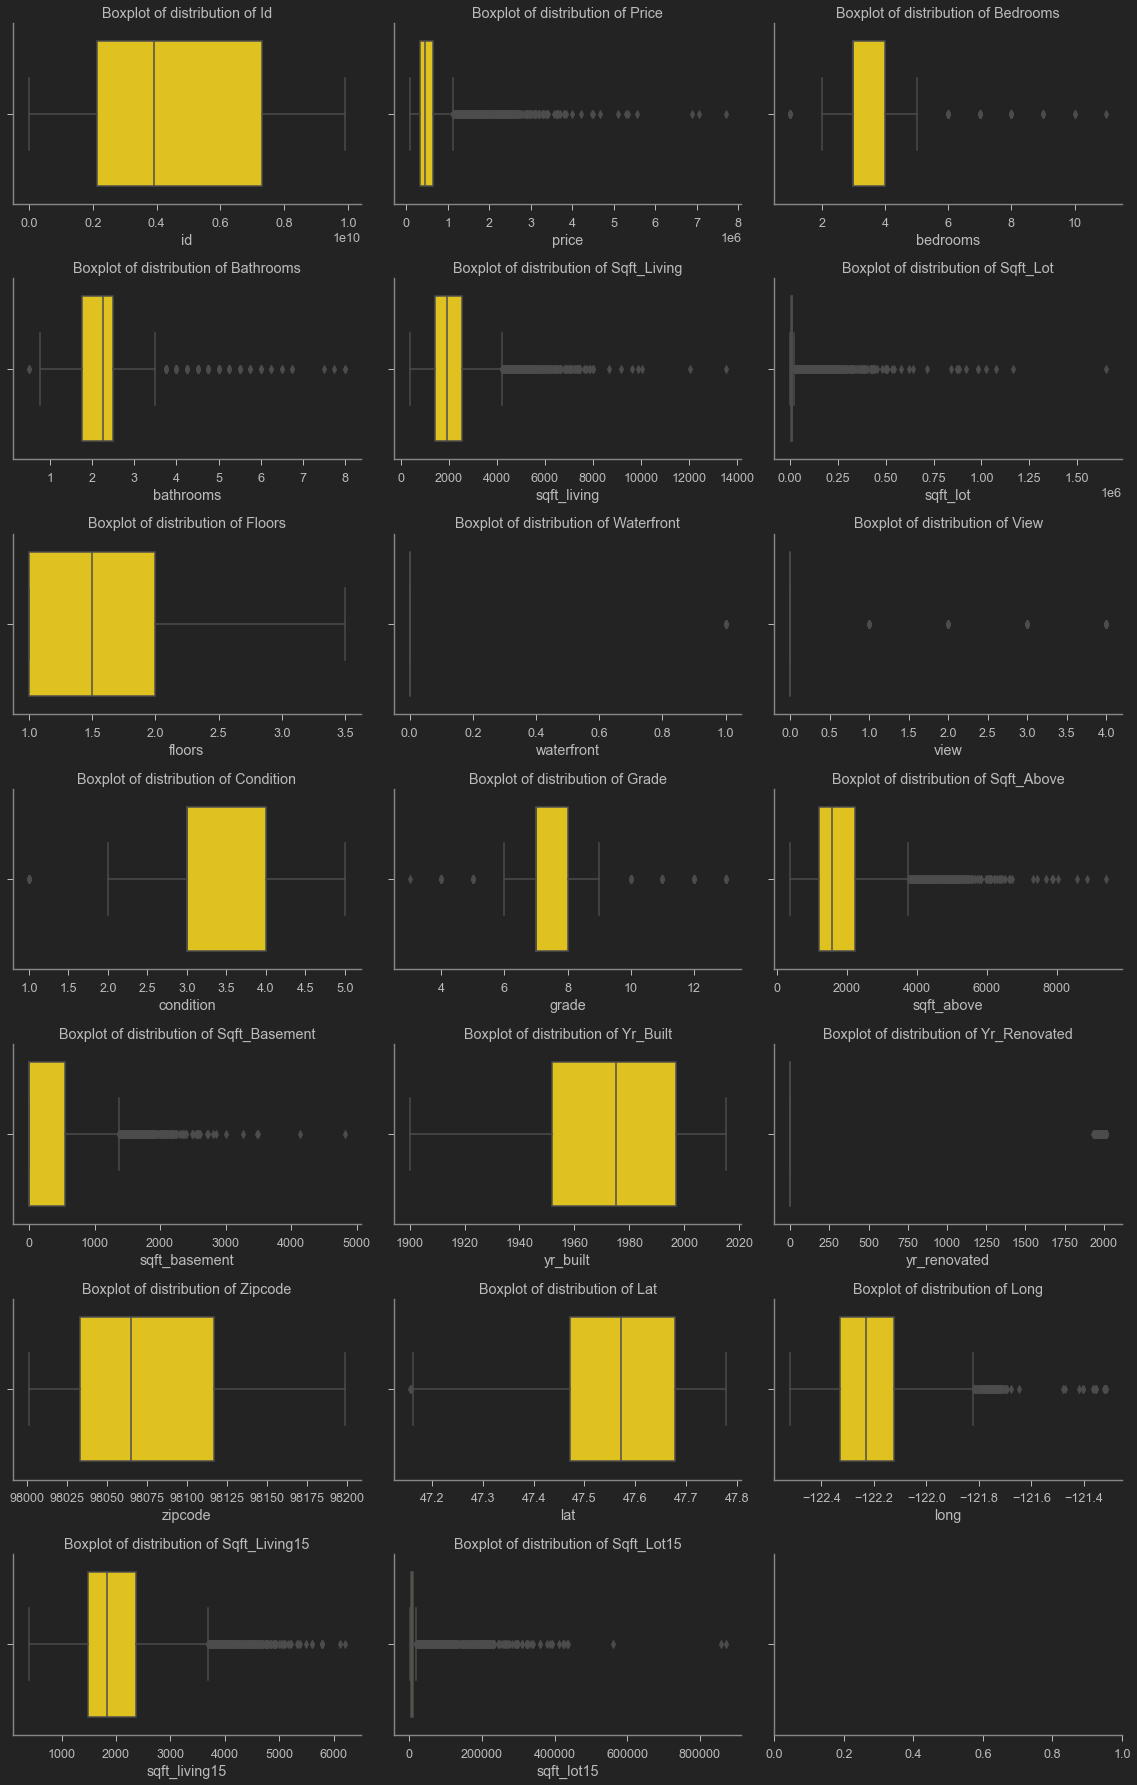

In [30]:
check_outliers_in_df(df=df_model,show_dfs=False)

From the chart potential candidate for formula based out lier removal are:
- price
- bathrooms
- bathrooms
- sqft_living
- sqft_lot
- floors
- condition
- sqft_above
- sqft_basement

And for manual outlier removal: 
- distance_from_downtown_mile

In [31]:
to_remove_outliers_from = [
    'price', 'bathrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
    'condition', 'sqft_above', 'sqft_basement'
]

Price data loss from original dataset using IQR 5.37 %
Price data loss from original dataset using Z 1.88 %
________________________________________________________________________________________________________________________________________________________________


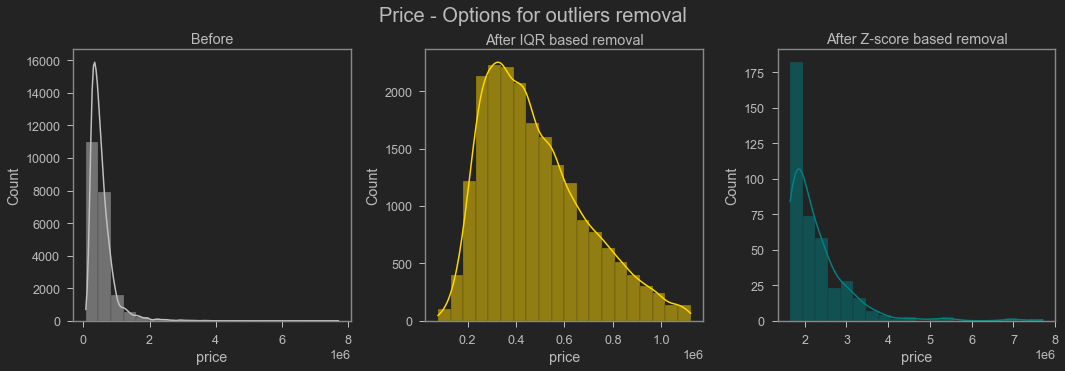

Bathrooms data loss from original dataset using IQR 2.61 %
Bathrooms data loss from original dataset using Z 0.87 %
________________________________________________________________________________________________________________________________________________________________


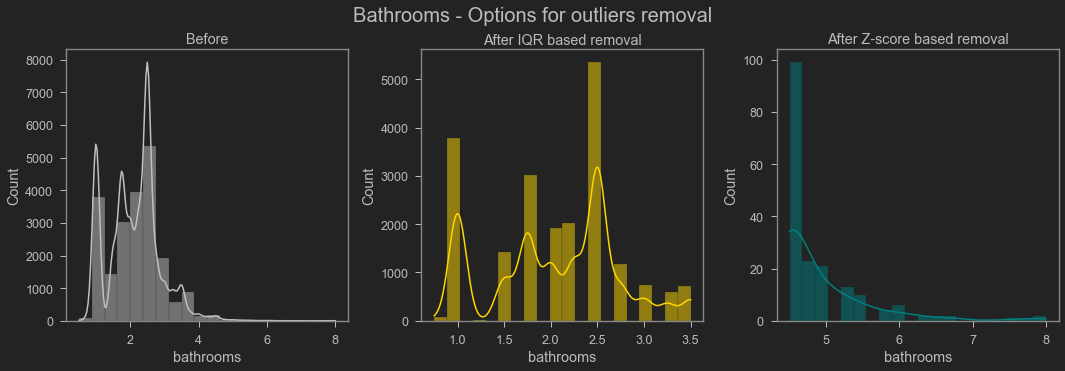

Bathrooms data loss from original dataset using IQR 2.61 %
Bathrooms data loss from original dataset using Z 0.87 %
________________________________________________________________________________________________________________________________________________________________


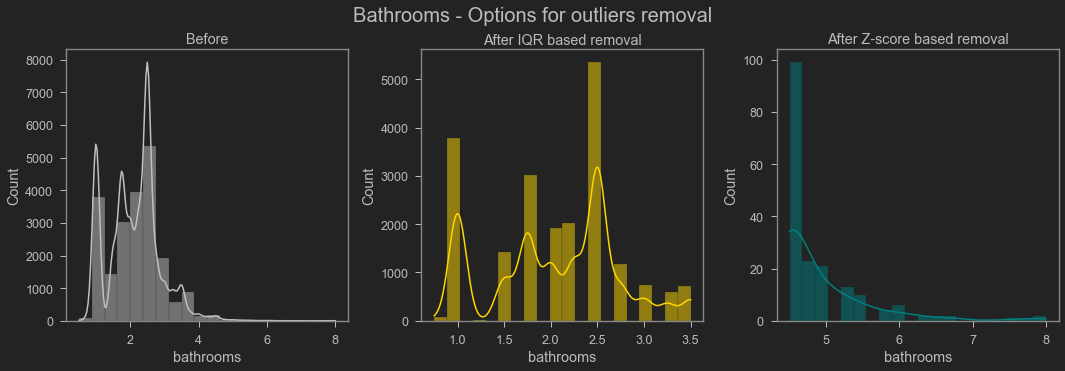

Sqft_Living data loss from original dataset using IQR 2.65 %
Sqft_Living data loss from original dataset using Z 1.15 %
________________________________________________________________________________________________________________________________________________________________


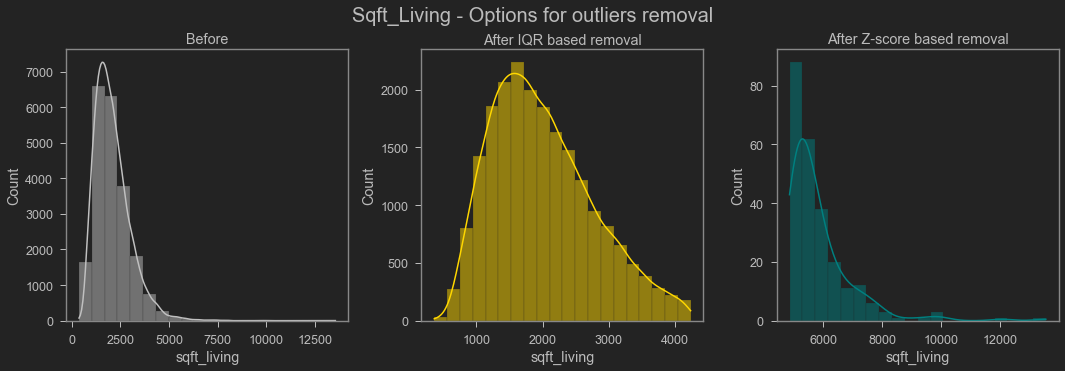

Sqft_Lot data loss from original dataset using IQR 11.23 %
Sqft_Lot data loss from original dataset using Z 1.6 %
________________________________________________________________________________________________________________________________________________________________


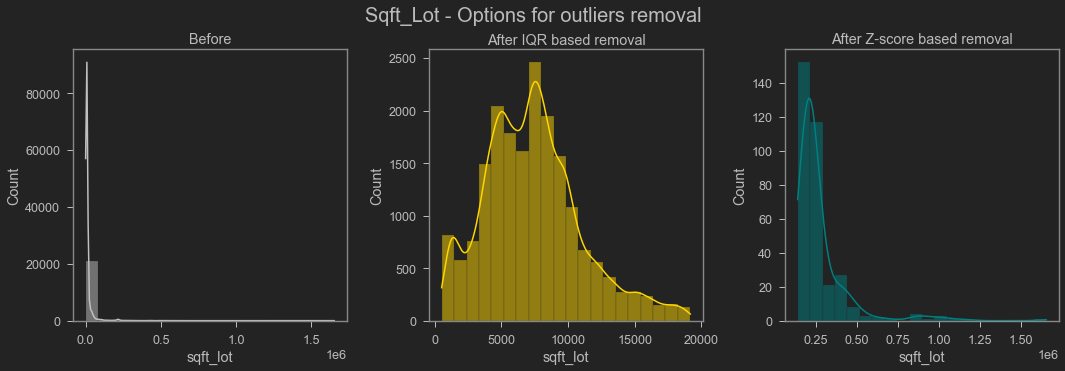

Floors data loss from original dataset using IQR 0.0 %
Floors data loss from original dataset using Z 0.03 %


C:\Users\tamji\anaconda3\envs\learn-env-upd\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


________________________________________________________________________________________________________________________________________________________________


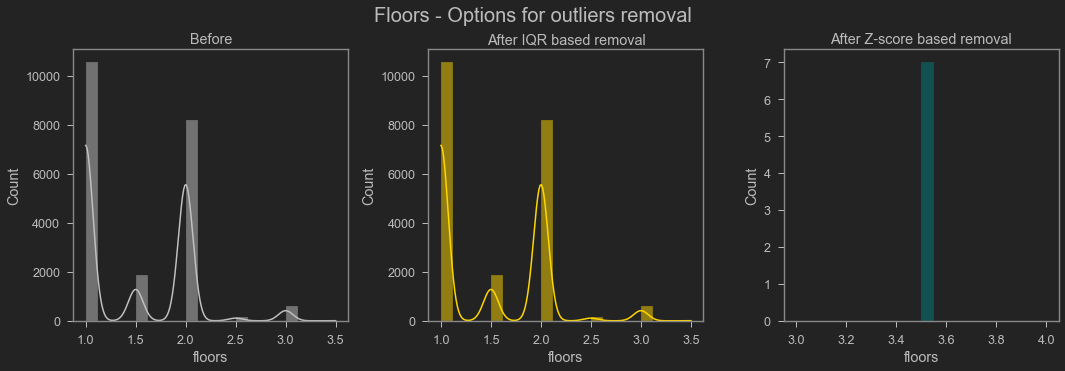

Condition data loss from original dataset using IQR 0.13 %
Condition data loss from original dataset using Z 0.13 %


C:\Users\tamji\anaconda3\envs\learn-env-upd\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


________________________________________________________________________________________________________________________________________________________________


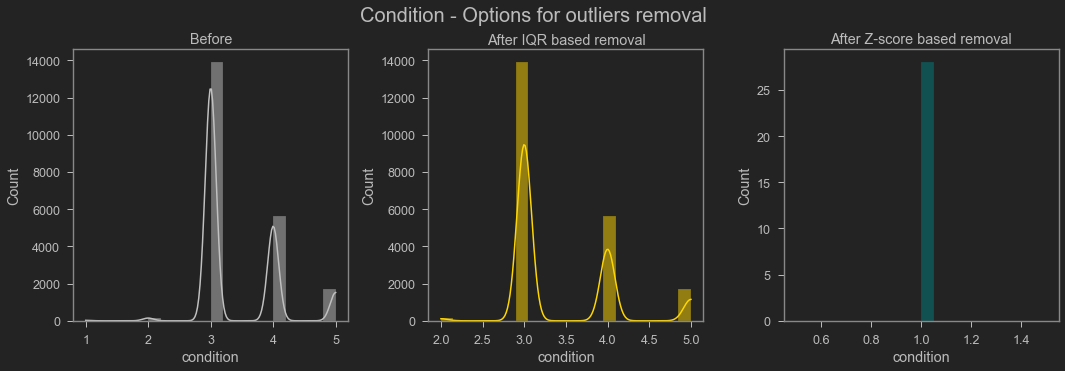

Sqft_Above data loss from original dataset using IQR 2.8 %
Sqft_Above data loss from original dataset using Z 1.18 %
________________________________________________________________________________________________________________________________________________________________


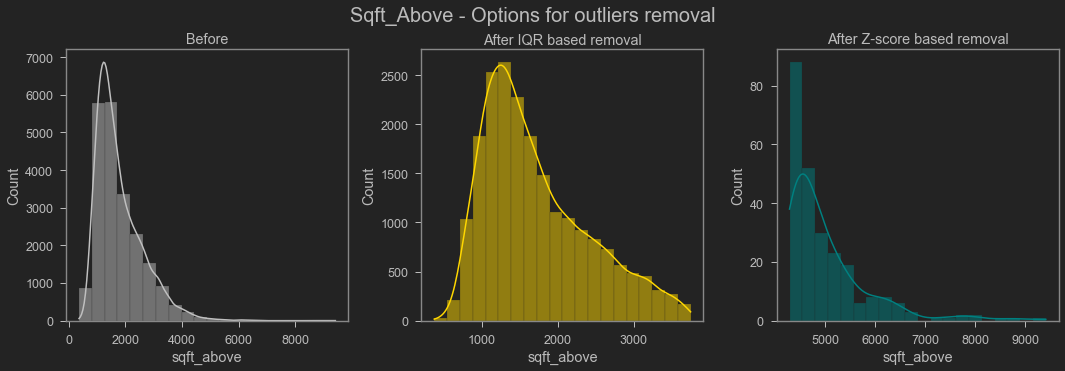

Sqft_Basement data loss from original dataset using IQR 2.6 %
Sqft_Basement data loss from original dataset using Z 1.14 %
________________________________________________________________________________________________________________________________________________________________


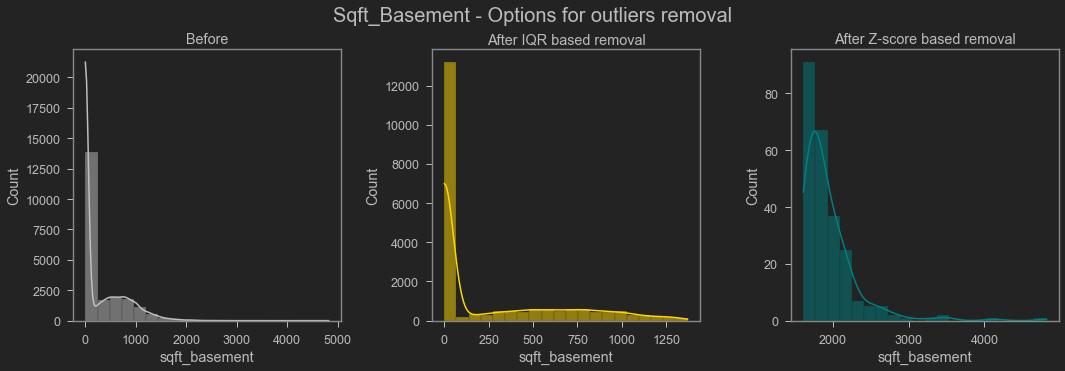

In [32]:
for item in to_remove_outliers_from:
    IQR_df = df_model[find_outliers_IQR(df_model[item])]
    IQR_df_ = df_model[~find_outliers_IQR(df_model[item])]
    print(item.title(), "data loss from original dataset using IQR",
          round((len(IQR_df) / len(df_model)) * 100, 2), '%')
    Z_price_price = df_model[find_outliers_Z(df_model[item])]
    Z_price_price_ = df_model[find_outliers_Z(df_model[item])]
    print(item.title(), "data loss from original dataset using Z",
          round((len(Z_price_price) / len(df_model)) * 100, 2), '%')
    # left
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    sns.histplot(data=df_model, x=item, color='silver', bins=20, kde=True)
    plt.title('Before')
    # middle
    plt.subplot(1, 3, 2)
    sns.histplot(data=IQR_df_, x=item, color='gold', bins=20, kde=True)
    plt.title('After IQR based removal')
    # right
    plt.subplot(1, 3, 3)
    sns.histplot(data=Z_price_price_, x=item, color='teal', bins=20, kde=True)
    plt.title('After Z-score based removal')
    plt.tight_layout()
    plt.suptitle(f'{item.title()} - Options for outliers removal',
                 va='bottom',
                 fontsize=20)
    print(f'{"_"*160}')
    plt.show()

Across the board outlier removal by using IQR is the winner. Now removing those outliers. bathroom,sqft-basement can use Z-score. Maybe later.

In [33]:
## checkpoint
df_model_2 = df_model.copy()

In [34]:
# droping data and generating info
n = 0
while n < len(to_remove_outliers_from):
    print("Dropping Data".capitalize())
    print(f'{"_"*160}')
    for item in to_remove_outliers_from:
        print(item.capitalize())
        dropped_rows= len(df_model_2[find_outliers_IQR(df_model_2[item])])
        original_rows = len(df_model_2)
        ###
        df_model_2 = df_model_2[~find_outliers_IQR(df_model_2[item])]
        print(f'   Data dropped: {dropped_rows}')
        print(f'   Data loss : {round((dropped_rows/original_rows)*100,4)}%')
        
        n = n+1
    print(f'{"_"*160}')

Dropping data
________________________________________________________________________________________________________________________________________________________________
Price
   Data dropped: 1151
   Data loss : 5.3737%
Bathrooms
   Data dropped: 99
   Data loss : 0.4885%
Bathrooms
   Data dropped: 0
   Data loss : 0.0%
Sqft_living
   Data dropped: 272
   Data loss : 1.3486%
Sqft_lot
   Data dropped: 2089
   Data loss : 10.4991%
Floors
   Data dropped: 0
   Data loss : 0.0%
Condition
   Data dropped: 20
   Data loss : 0.1123%
Sqft_above
   Data dropped: 449
   Data loss : 2.5242%
Sqft_basement
   Data dropped: 359
   Data loss : 2.0705%
________________________________________________________________________________________________________________________________________________________________


In [35]:
len_new = len(df_model_2)
len_old = len(df_model)
print('New utlier removed dataset length:', len_new)
print('Old dataset length:', len_old)
print(f'Total data loss: {round(abs((np.log(len_new/len_old)*100)),2)}%')

New utlier removed dataset length: 16980
Old dataset length: 21419
Total data loss: 23.22%


In [36]:
df_model_2

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21414,263000018,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21415,6600060120,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21416,1523300141,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21417,291310100,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


## Ordinary Least Squares

In [37]:
def OLS_sm(df,
           dependant_var='price',
           numeric_features=[],
           categorical_features=[],
           verbose=False,
           show_summary=True,
           show_plots=True,
           target_is_dollar=True):
    """
    ### Uses formula based statsmodels regression for OLS. ###
    
    Displays a statsmodels.iolib.summary.Summary object containing summary of OLS analysis. 
    Returns a statsmodels.regression.linear_model.RegressionResultsWrapper which can be used to access other options available.

    Parameters:
    ===========
        df = pandas.DataFrame; no default. 
                Input dataset to use for OLS.
        dependant_var = str; default: 'price'. 
                Dependent variable.
        numeric_features = list; default = []. 
                Identify numeric features.
        categorical_features = list; default = []. 
                Identify categorical features.
        verbose = boolean; default: False. 
                Shows some formula used and drop information.
                    `True` shows information.
                    `False` does not show information.
        show_summary = boolean; default: False. 
                Shows summary report.
                    `True` shows information.
                    `False` does not show information.
        show_plots = boolean; default: True. 
                Shows summary and Homoscedasticity information.
                    `True` shows information.
                    `False` does not show information.
        target_is_dollar = boolean; default: True. 
                Modify chart axis label.
                    `True` shows information.
                    `False` does not show information.    
    Under-The-Hood:
    =============
    --{Major Steps}--
        
        ## Regression
        cate = ' + '.join([f'C({x})' for x in categorical_features])
        nume = ' + '.join([f'{x}' for x in numeric_features])
        formula = f'{dependant_var} ~ {nume} + {cate}'
        
        ## plots
        # plot on the left
        sm.qqplot(multiple_regression.resid,
                  dist=stats.norm,
                  line='45',
                  fit=True,
                  ax=ax1)
        # plot on the right
        ax2.scatter(x=multiple_regression.fittedvalues,
                    y=multiple_regression.resid,
                    s=4,
                    color='gold')
    
    Note:
    =====
        Make sure that every column in the DataFrame has the correct dtype.
        Numeric values stored as str (i.e, object) will make stats model assume that those are categorical variable.
        If Erros, check df to see if the passed feature is available in the DataFrame.
    
    Issues:
    =======
        - Output control is not clear.
    
    Changelog:
    ==========
        - changed `resid`, was using `resid_pearson`.
    
    -- ver: 1.3 --
    """
    cate = ' + '.join([f'C({x})' for x in categorical_features])
    nume = ' + '.join([f'{x}' for x in numeric_features])
    if len(cate)==0:
        formula = f'{dependant_var} ~ {nume}'
    else:
        formula = f'{dependant_var} ~ {nume} + {cate}'
    print('Formula for the OLS model: ', formula)
    # OLS regressor
    multiple_regression = smf.ols(formula=formula, data=df).fit()

    if verbose:
        show_summary = True
        show_plots = True

    if show_summary:
        display(multiple_regression.summary())
    if show_plots:
        # plotting
        # plot 1
        fig, (ax1,
              ax2) = plt.subplots(ncols=2,
                                  figsize=(10, 5),
                                  gridspec_kw={'width_ratios': [0.6, 0.4]})
        sm.qqplot(multiple_regression.resid,
                  dist=stats.norm,
                  line='45',
                  fit=True,
                  ax=ax1)
        ax1.set_title('Q-Q Plot', fontdict={"size": 15})
        # plot 2
        # uses The predicted values for the original (unwhitened) design.
        ax2.scatter(x=multiple_regression.fittedvalues, 
                    y=multiple_regression.resid,
                    s=4,
                    color='gold')
        if target_is_dollar:
            ax2.yaxis.set_major_formatter(format_number)
        ax2.set(xlabel='Predicted', ylabel='Residuals')
        ax2.axhline(y=0, c='r', lw=4, ls='--')
        ax2.set_title('Predicted VS Residuals', fontdict={"size": 15})
        plt.suptitle('Visual Check of Residuals for Homoscedasticity',
                     ha='center',
                     va='bottom',
                     fontdict={"size": 25})
        plt.tight_layout()
    if verbose == False and show_summary == False and show_plots == True:
        print('r_sq:', round(multiple_regression.rsquared, 4))
    return multiple_regression

> With outliers dropped data

Formula for the OLS model:  price ~ bedrooms + bathrooms + sqft_living + sqft_lot + floors + sqft_above + sqft_basement + yr_built + lat + long + sqft_living15 + sqft_lot15 + C(waterfront) + C(condition) + C(grade) + C(zipcode)
r_sq: 0.8237


,features,p_values
0,Intercept,0.2753
1,C(grade)[T.4],0.1850
2,C(grade)[T.5],0.1160
3,C(grade)[T.6],0.1785
4,C(grade)[T.7],0.3121
5,C(grade)[T.8],0.6230
6,C(grade)[T.9],0.6990
7,C(grade)[T.10],0.4207
8,C(grade)[T.11],0.0799
9,C(zipcode)[T.98002],0.0834


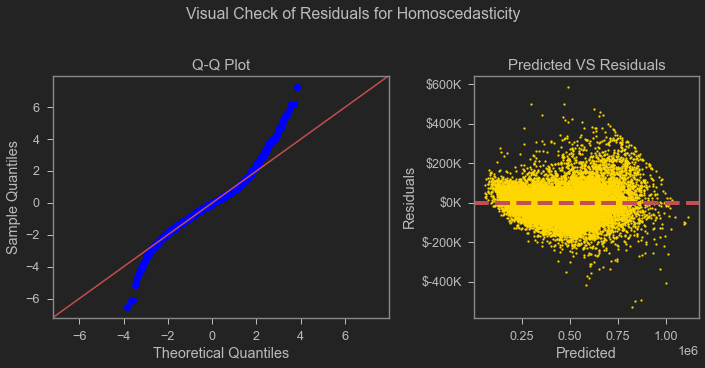

In [38]:
x2 = OLS_sm(df=df_model_2,
              numeric_features=[
                  'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
                  'sqft_above', 'sqft_basement', 'yr_built', 'lat', 'long',
                  'sqft_living15', 'sqft_lot15'
              ],
              dependant_var='price',
              categorical_features=[
                  'waterfront', 'condition', 'grade',
                  'zipcode'
              ],
              show_summary=False)
check_for_high_p_val(x2)

### Consider the above one as base model

It has features with high p value, and residual plots are very abnormal.

## Scaling

Robust statistics have good  performance when distributions  are not normal. These robust estimators typically have inferior statistical efficiency compared to conventional estimators for data drawn from a distribution without outliers (such as a normal distribution), but have superior efficiency for data drawn from a mixture distribution or from a heavy-tailed distribution, for which non-robust measures such as the standard deviation should not be used.

This matches the dataset characteristics.


### Based on mean and IQR range

In [39]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler

In [40]:
scaler = MinMaxScaler()

In [41]:
# checkpoint
IQR__df = df_model_2.copy()

In [42]:

IQR__df = df_model_2.copy()
IQR__df.reset_index(inplace=True)

X__price = IQR__df.drop(columns=[
    'price', 'zipcode', 'index', 'waterfront', 'condition','view', 'grade'
])
X_price_only = IQR__df[[
    'price', 'zipcode', 'waterfront', 'condition','view', 'grade'
]]
# sans price
X_unscaled_pr = scaler.fit_transform(X__price)

df_for_last_step = pd.DataFrame(X_unscaled_pr, columns=X__price.columns)
df_for_last_step = pd.concat([X_price_only, df_for_last_step], axis=1)

In [43]:
# prepping variables
df_model_2 = None

In [44]:
df_model_2 = df_for_last_step

In [45]:
df_model_2.describe()

,price,zipcode,waterfront,condition,view,grade,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
count,1.698000e+04,16980.000000,16980.000000,16980.000000,16980.000000,16980.000000,16980.000000,16980.000000,16980.000000,16980.000000,16980.000000,16980.000000,16980.000000,16980.000000,16980.000000,16980.000000,16980.000000,16980.000000,16980.000000,16980.000000
mean,4.507008e+05,98082.127032,0.001355,3.416137,0.135866,7.395642,0.479145,0.225424,0.422438,0.402000,0.373956,0.186949,0.423417,0.187056,0.603248,0.029282,0.649205,0.234768,0.300615,0.032938
std,1.919923e+05,53.932524,0.036780,0.645086,0.558997,0.907010,0.289536,0.084667,0.190594,0.172133,0.194372,0.217778,0.206605,0.281476,0.260946,0.167775,0.224099,0.110754,0.115816,0.021783
min,8.000000e+04,98001.000000,0.000000,2.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.024988e+05,98034.000000,0.000000,3.000000,0.000000,7.000000,0.233650,0.200000,0.285714,0.269444,0.239216,0.000000,0.269891,0.000000,0.426087,0.000000,0.503941,0.145363,0.216036,0.021175
50%,4.150000e+05,98074.000000,0.000000,3.000000,0.000000,7.000000,0.409147,0.200000,0.428571,0.383333,0.371768,0.000000,0.375044,0.000000,0.608696,0.000000,0.664951,0.201337,0.280624,0.033224
75%,5.636125e+05,98119.000000,0.000000,4.000000,0.000000,8.000000,0.757962,0.300000,0.571429,0.519444,0.485898,0.400000,0.546793,0.376000,0.834783,0.000000,0.843976,0.299081,0.369710,0.041548
max,1.120000e+06,98199.000000,1.000000,5.000000,4.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Check for multicolinerity

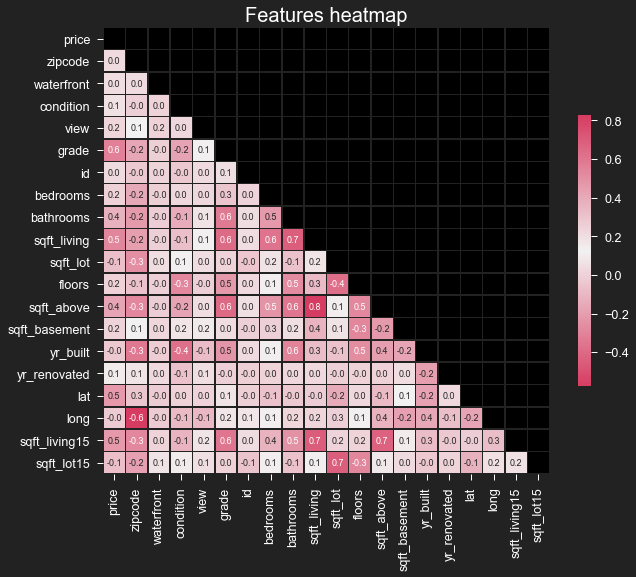

In [46]:
heatmap_DataFrame(df_model_2)

In [47]:
correlation_top_bottom(df_model_2.corr())

Positive correlations:
   index                  feature_combo  correlation
0    192     sqft_above and sqft_living     0.829051
1    198  sqft_living and sqft_living15     0.701537
2    369  sqft_living15 and sqft_living     0.701537
3    219        sqft_lot and sqft_lot15     0.694883
4    169      sqft_living and bathrooms     0.693949
5    258   sqft_above and sqft_living15     0.676673
6    112           grade and sqft_above     0.647729
7    245           sqft_above and grade     0.647729
8    109          grade and sqft_living     0.644232
9    149       sqft_living and bedrooms     0.613292

----------------------------------------------------------------------
Negative correlations:
   index              feature_combo  correlation
0     37           zipcode and long    -0.577685
1    211        floors and sqft_lot    -0.380024
2     74     yr_built and condition    -0.369420
3     34       zipcode and yr_built    -0.344266
4    233   floors and sqft_basement    -0.287774
5    

In [48]:
def correlation_feat(df, threshold=0.75):
    feature_corr = set()  # Set of all the names of correlated columns
    corr_matrix = df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]
                   ) > threshold:  # absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                feature_corr.add(colname)
    return feature_corr

In [49]:
corr_features = correlation_feat(df_model_2, 0.75)
print('correlated features: ', len(set(corr_features)))
print('correlated features: ', corr_features)

correlated features:  1
correlated features:  {'sqft_above'}


In [50]:
df_model_2.drop(['sqft_above','lat','long','id'],axis=1,inplace=True)

Dropping `sqft_above` from the data set. also dropping redundant location feature `lat` and `long`.

In [51]:
correlation_top_bottom(df_model_2.corr())

Positive correlations:
   index                  feature_combo  correlation
0    232  sqft_living15 and sqft_living     0.701537
1    142  sqft_living and sqft_living15     0.701537
2    159        sqft_lot and sqft_lot15     0.694883
3    120      sqft_living and bathrooms     0.693949
4     88          grade and sqft_living     0.644232
5    104       sqft_living and bedrooms     0.613292
6     94        grade and sqft_living15     0.606079
7     87            grade and bathrooms     0.585044
8      5                grade and price     0.559944
9    124         bathrooms and yr_built     0.551385

----------------------------------------------------------------------
Negative correlations:
   index              feature_combo  correlation
0    154        floors and sqft_lot    -0.380024
1     60     yr_built and condition    -0.369420
2     28       zipcode and yr_built    -0.344266
3    171   floors and sqft_basement    -0.287774
4    175      floors and sqft_lot15    -0.287194
5    

# Feature Selection

## Exploratory Simple  OLS a.k.a. Univariate OLS or ANNOVA 

> On all data

Dependent variable is price. A list containing all of the features were regressed. That list is:


In [52]:
all_feat=df_model_2.columns.to_list()

In [53]:
categorical_feat_model = ['zipcode', 'waterfront', 'condition','view', 'grade']

In [137]:
numeric_feat = []
for i in all_feat:
    if i not in categorical_feat_model:
        numeric_feat.append(i)
numeric_feat

['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'sqft_living15',
 'sqft_lot15']

In [138]:
stat_list = []
for idx, column in enumerate(df_model_2.columns):
    regression_target = 'price'
    # for dealing with categorical variables
    temp_df = df_model.copy()
    if column in categorical_feat_model:
        f = f'{regression_target} ~ C({column})'
    else:
        f = f'{regression_target} ~ {column}'
    model = smf.ols(formula=f, data=temp_df).fit()
    temp_dict = {
        'name': column,
        'r_sq': model.rsquared,
        'intercept': model.params[0],
        'beta': model.params[1],
        'p_val': model.pvalues[1],
        'Jarque-Bera': sms.jarque_bera(model.resid)[0] 
    }
    stat_list.append(temp_dict)
df_stat = pd.DataFrame(stat_list).set_index('name')
df_stat.sort_values(by='r_sq',
                    ascending=False).style.set_precision(4).set_properties(
                        **{'color': 'lawngreen'})

,r_sq,intercept,beta,p_val,Jarque-Bera
name,,,,,
price,1.0000,-0.0000,1.0000,0.0000,1090019.8916
grade,0.5203,262000.0000,-49998.1481,0.8473,786068.7554
sqft_living,0.4926,-44772.1777,281.0674,0.0000,538438.0071
zipcode,0.4067,281383.6536,-47299.7805,0.0603,2652223.2543
sqft_living15,0.3417,-83130.6098,313.7501,0.0000,1893645.1403
bathrooms,0.2769,7153.9877,251873.6006,0.0000,876367.7648
view,0.1645,497514.0596,316363.3811,0.0000,1071382.8546
sqft_basement,0.1029,464034.7250,268.2842,0.0000,877606.3514
bedrooms,0.1003,105504.0633,129050.2701,0.0000,1161922.4250


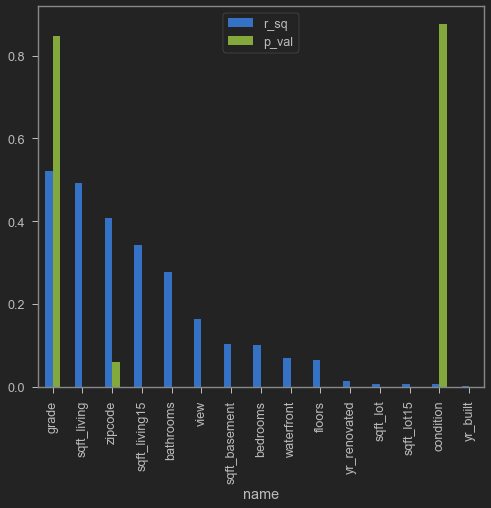

In [139]:
for_plot_df=df_stat.sort_values(by='r_sq',ascending=False)[1:]
ax = for_plot_df[['r_sq','p_val']].plot(kind='bar',rot=90)
ax.set_xticks(np.arange(len(for_plot_df)))
ax.set_autoscalex_on(False)

## Exploratory Multiple OLS a.k.a Multivariate OLS

In [57]:
numeric_feat.remove('price')

Formula for the OLS model:  price ~ bedrooms + bathrooms + sqft_living + sqft_lot + floors + sqft_basement + yr_built + yr_renovated + sqft_living15 + sqft_lot15 + C(zipcode) + C(waterfront) + C(condition) + C(view) + C(grade)
r_sq: 0.8325


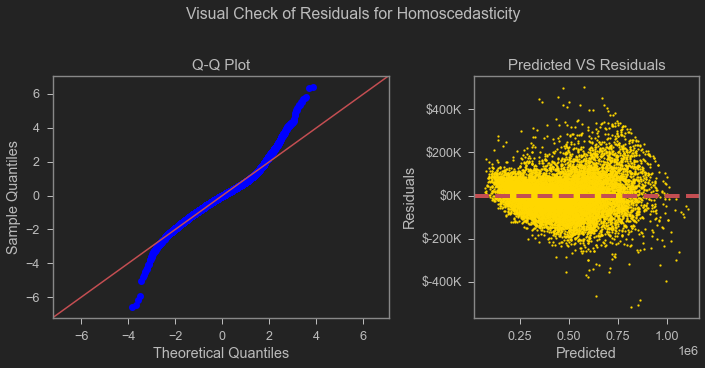

In [58]:
OLS_sm(df=df_model_2,
       numeric_features=numeric_feat,
       dependant_var='price',
       categorical_features=categorical_feat_model,
       show_summary=False);

## One Hot Encoding

In [93]:
categorical_feat_model

['zipcode', 'waterfront', 'condition', 'view', 'grade']

In [59]:
df_model_processed_ohe = pd.get_dummies(df_model_2,
                                        columns=categorical_feat_model,
                                        sparse=False,
                                        drop_first=True)
df_model_processed_ohe

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,...,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,waterfront_1,condition_3,condition_4,condition_5,view_1,view_2,view_3,view_4,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11
0,221900.0,0.2,0.142857,0.225000,0.293478,0.0,0.000,0.478261,0.000000,0.195991,0.025513,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,538000.0,0.2,0.500000,0.611111,0.384554,0.4,0.320,0.443478,0.988089,0.273942,0.035664,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,180000.0,0.1,0.142857,0.111111,0.542334,0.0,0.000,0.286957,0.000000,0.503341,0.037823,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,604000.0,0.3,0.714286,0.441667,0.256293,0.0,0.728,0.565217,0.000000,0.200445,0.022196,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
4,510000.0,0.2,0.428571,0.363889,0.432494,0.0,0.000,0.756522,0.000000,0.298441,0.034970,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16975,360000.0,0.2,0.571429,0.322222,0.034954,0.8,0.000,0.947826,0.000000,0.238307,0.004379,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
16976,400000.0,0.3,0.571429,0.538889,0.302803,0.4,0.000,0.991304,0.000000,0.305122,0.033423,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
16977,402101.0,0.1,0.071429,0.180556,0.047483,0.4,0.000,0.947826,0.000000,0.124722,0.006920,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
16978,400000.0,0.2,0.571429,0.341667,0.106865,0.4,0.000,0.904348,0.000000,0.211581,0.003246,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0


## Feature selection methods

### Filter methods

Already applied filtering by correlation.

### Wrapper  methods

#### Forward Selection using Statsmodels

In [60]:
def forward_selected(data, response):
    """
    Source: https://planspace.org/20150423-forward_selection_with_statsmodels/
    __________________________________________________________________________
    
    Linear model created by forward selection.

    Parameters:
    ===========
    data : pandas DataFrame with all possible predictors and response.
    response: string, name of response column in data.
    
    Returns:
    ========
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        r_sq_scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            r_sq_scores_with_candidates.append((score, candidate))

        r_sq_scores_with_candidates.sort()
        best_new_score, best_candidate = r_sq_scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    
    # plotting
    # plot 1
    fig, (ax1,
          ax2) = plt.subplots(ncols=2,
                              figsize=(10, 5),
                              gridspec_kw={'width_ratios': [0.6, 0.4]})
    sm.qqplot(model.resid,
              dist=stats.norm,
              line='45',
              fit=True,
              ax=ax1)
    ax1.set_title('Q-Q Plot', fontdict={"size": 15})
    # plot 2

    ax2.scatter(x=model.fittedvalues,
                y=model.resid,
                s=4,
                color='gold')
    ax2.set(xlabel='Predicted', ylabel='Reseduals')
    ax2.axhline(y=0, c='r', lw=4, ls='--')
    ax2.set_title('Predicted VS Reseduals', fontdict={"size": 15})
    plt.suptitle('Visual Check of Reseduals for Homoscedasticity',
                 ha='center',
                 va='bottom',
                 fontdict={"size": 25})
    plt.tight_layout()
    return model

In [61]:
def catch_forward_selected_steps(data, response):
    """
    Optimal feature selection helper formula.
    
    Modified from
    Source: https://planspace.org/20150423-forward_selection_with_statsmodels/
    __________________________________________________________________________
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    li = []
    n =0
    while remaining and current_score == best_new_score:
        r_sq_scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            r_sq_scores_with_candidates.append((score, candidate))
        r_sq_scores_with_candidates.sort()
        best_new_score, best_candidate = r_sq_scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
            n+=1
            tem_d = {'variable_count': n,'r_sq_adj':current_score}
            li.append(tem_d)
    return li

In [62]:
# # Without OHE, this is wrong approach
# catch = pd.DataFrame(catch_forward_selected_steps(df_model_2, 'price'))
# sns.lineplot(x='variable_count',y='r_sq_adj',data=catch);
# catch

,variable_count,r_sq_adj
0,1,0.292216
1,2,0.340314
2,3,0.378273
3,4,0.419072
4,5,0.444534
...,...,...
88,89,0.831303
89,90,0.831377
90,91,0.831443
91,92,0.831490


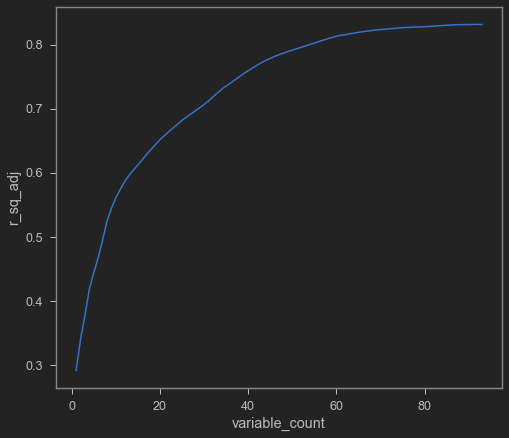

In [118]:
# with OHE
name_list = [x.split(".")[0].replace("-","") for x in list(df_model_processed_ohe.columns)]
df_model_processed_ohe.columns = name_list

catch_ = pd.DataFrame(catch_forward_selected_steps(df_model_processed_ohe, 'price'))
sns.lineplot(x='variable_count',y='r_sq_adj',data=catch_);
catch_

Optimal number of features where diminishing return starts to occur.

price ~ sqft_living + yr_built + sqft_lot + sqft_living15 + zipcode_98004 + grade_9 + grade_8 + grade_10 + grade_7 + zipcode_98023 + zipcode_98033 + zipcode_98040 + zipcode_98092 + zipcode_98042 + zipcode_98003 + zipcode_98058 + zipcode_98038 + zipcode_98030 + zipcode_98031 + zipcode_98055 + zipcode_98002 + zipcode_98198 + zipcode_98032 + zipcode_98178 + zipcode_98168 + zipcode_98022 + zipcode_98112 + view_4 + zipcode_98199 + zipcode_98115 + zipcode_98103 + zipcode_98117 + zipcode_98119 + zipcode_98105 + zipcode_98107 + zipcode_98109 + zipcode_98116 + zipcode_98102 + zipcode_98122 + zipcode_98052 + zipcode_98006 + zipcode_98005 + zipcode_98053 + zipcode_98136 + zipcode_98144 + zipcode_98008 + zipcode_98029 + condition_5 + view_2 + zipcode_98188 + view_3 + zipcode_98027 + zipcode_98007 + zipcode_98074 + zipcode_98075 + zipcode_98034 + zipcode_98125 + zipcode_98039 + zipcode_98126 + zipcode_98177 + grade_11 + zipcode_98133 + zipcode_98118 + sqft_basement + condition_4 + yr_renovated + vi

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     902.0
Date:                Thu, 06 May 2021   Prob (F-statistic):               0.00
Time:                        11:08:27   Log-Likelihood:            -2.1549e+05
No. Observations:               16980   AIC:                         4.312e+05
Df Residuals:                   16886   BIC:                         4.319e+05
Df Model:                          93                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       358.5030   9402.394      0.038      0.970   -1.81e+04    1.88e+04
sqft_living    4.202e+05   7984.909     52.619      0.000    4.05e+05    4.36e+05
yr_built      -5.503e+04   4241.620    -12.973      0.000   -6.33e+04   -4.67e+04
sqft_lot       2.846e+04   5254.951      5.415      0.000    1.82e+04    3.88e+04
sqft_living15  1.268e+05   8704.864     14.565      0.000     1.1e+05    1.44e+05
zipcode_98004  5.179e+05   8415.002     61.544      0.000    5.01e+05    5.34e+05
grade_9        1.333e+05   3917.175     34.023      0.000    1.26e+05    1.41e+05
grade_8        6.383e+04   2913.731     21.905      0.000    5.81e+04    6.95e+04
grade_10        1.69e+05   6162.199     27.430      0.000    1.57e+05    1.81e+05
grade_7        2.481e+04   2310.519     10.738      0.000    2.03e+04    2.93e+04
zipcode_98023 -1.531e+04   6021.527     -2.543      0.011   -2.71e+04   -3509.156
zipcode_98033  3.083e+05   6464.914     47.692      0.000    2.96e+05    3.21e+05
zipcode_98040  4.088e+05   8471.034     48.258      0.000    3.92e+05    4.25e+05
zipcode_98092 -2.137e+04   6860.706     -3.116      0.002   -3.48e+04   -7926.891
zipcode_98042  1.036e+04   6031.311      1.719      0.086   -1457.114    2.22e+04
zipcode_98003   164.0590   6815.989      0.024      0.981   -1.32e+04    1.35e+04
zipcode_98058  3.472e+04   6220.898      5.581      0.000    2.25e+04    4.69e+04
zipcode_98038  3.809e+04   5927.785      6.425      0.000    2.65e+04    4.97e+04
zipcode_98030  4835.8367   6965.972      0.694      0.488   -8818.196    1.85e+04
zipcode_98031  1.403e+04   6874.921      2.041      0.041     556.714    2.75e+04
zipcode_98055  4.022e+04   6963.475      5.775      0.000    2.66e+04    5.39e+04
zipcode_98002  7860.2176   7430.525      1.058      0.290   -6704.388    2.24e+04
zipcode_98198  2.379e+04   6936.153      3.430      0.001    1.02e+04    3.74e+04
zipcode_98032 -1171.8369   8816.101     -0.133      0.894   -1.85e+04    1.61e+04
zipcode_98178  4.752e+04   7024.370      6.765      0.000    3.37e+04    6.13e+04
zipcode_98168  4.749e+04   7137.924      6.653      0.000    3.35e+04    6.15e+04
zipcode_98022  3311.6741   8064.146      0.411      0.681   -1.25e+04    1.91e+04
zipcode_98112  4.284e+05   8104.151     52.859      0.000    4.12e+05    4.44e+05
view_4         1.777e+05   1.05e+04     16.865      0.000    1.57e+05    1.98e+05
zipcode_98199  3.542e+05   7052.659     50.228      0.000     3.4e+05    3.68e+05
zipcode_98115  3.182e+05   6036.878     52.708      0.000    3.06e+05     3.3e+05
zipcode_98103  3.237e+05   6117.394     52.916      0.000    3.12e+05    3.36e+05
zipcode_98117  3.146e+05   6102.517     51.550      0.000    3.03e+05    3.27e+05
zipcode_98119  4.041e+05   8309.118     48.637      0.000    3.88e+05     4.2e+05
zipcode_98105  3.771e+05   7879.598     47.860   

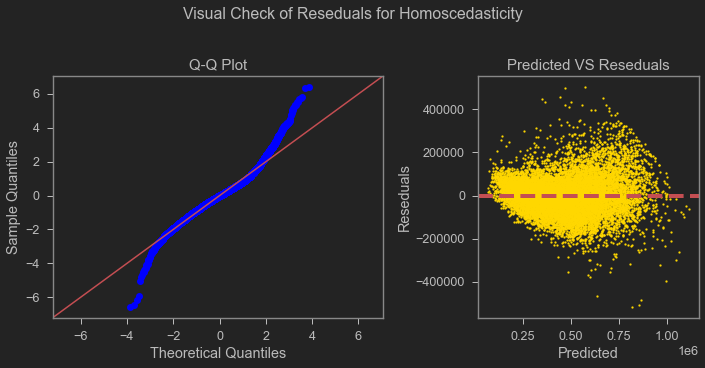

In [119]:
model = forward_selected(df_model_processed_ohe, 'price')
print(model.model.formula)
print(model.rsquared_adj)
model.summary()

### Hybrid feature Elimination

#### Recursive Feature Elimination Scikit-learn

In [65]:
X = df_model_processed_ohe.drop(columns='price').copy()

y = df_model_processed_ohe['price'].copy()

linreg = LinearRegression(n_jobs=8)
selector = RFE(linreg ,n_features_to_select=None) 
selector = selector.fit(X, y.values.ravel())

In [66]:
selector.support_

array([False, False,  True, False, False, False,  True, False,  True,
       False, False, False,  True,  True,  True,  True,  True, False,
        True, False, False, False, False, False,  True,  True,  True,
       False, False, False,  True,  True, False,  True,  True, False,
       False,  True,  True, False, False, False, False,  True, False,
        True,  True,  True,  True, False,  True,  True,  True, False,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
       False, False,  True, False, False, False,  True,  True, False,
       False, False, False, False,  True,  True, False, False, False,
       False, False, False, False,  True])

In [67]:
selector.ranking_ #The feature ranking

array([39, 20,  1, 37, 29, 26,  1, 27,  1, 33, 45, 49,  1,  1,  1,  1,  1,
       16,  1, 11, 13, 47, 40,  7,  1,  1,  1, 46, 43, 48,  1,  1, 34,  1,
        1, 44,  9,  1,  1, 32, 10, 36, 14,  1, 28,  1,  1,  1,  1, 38,  1,
        1,  1,  8,  1, 12,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, 15, 23,  1, 17, 30,  1, 31, 35, 41,  1,  1, 25, 24, 22, 19, 18,
        1,  1,  5,  2,  3,  4,  6, 42, 21,  1])

In [68]:
features_selection = pd.DataFrame(list(
    zip(X.columns.to_list(), selector.support_.tolist(),
        selector.ranking_.tolist())),
                                   columns=['Feature', 'keep', 'ranking'])
features_selection.sort_values(by="ranking", ascending=True)

,Feature,keep,ranking
47,zipcode_98075,True,1
37,zipcode_98052,True,1
38,zipcode_98053,True,1
43,zipcode_98065,True,1
45,zipcode_98072,True,1
...,...,...,...
10,zipcode_98002,False,45
27,zipcode_98030,False,46
21,zipcode_98022,False,47
29,zipcode_98032,False,48


Formula for the OLS model:  price ~ bedrooms + bathrooms + sqft_living + sqft_lot + floors + sqft_basement + yr_built + yr_renovated + sqft_living15 + sqft_lot15 + zipcode_98002 + zipcode_98003 + zipcode_98004 + zipcode_98005 + zipcode_98006 + zipcode_98007 + zipcode_98008 + zipcode_98010 + zipcode_98011 + zipcode_98014 + zipcode_98019 + zipcode_98022 + zipcode_98023 + zipcode_98024 + zipcode_98027 + zipcode_98028 + zipcode_98029 + zipcode_98030 + zipcode_98031 + zipcode_98032 + zipcode_98033 + zipcode_98034 + zipcode_98038 + zipcode_98039 + zipcode_98040 + zipcode_98042 + zipcode_98045 + zipcode_98052 + zipcode_98053 + zipcode_98055 + zipcode_98056 + zipcode_98058 + zipcode_98059 + zipcode_98065 + zipcode_98070 + zipcode_98072 + zipcode_98074 + zipcode_98075 + zipcode_98077 + zipcode_98092 + zipcode_98102 + zipcode_98103 + zipcode_98105 + zipcode_98106 + zipcode_98107 + zipcode_98108 + zipcode_98109 + zipcode_98112 + zipcode_98115 + zipcode_98116 + zipcode_98117 + zipcode_98118 + zipc

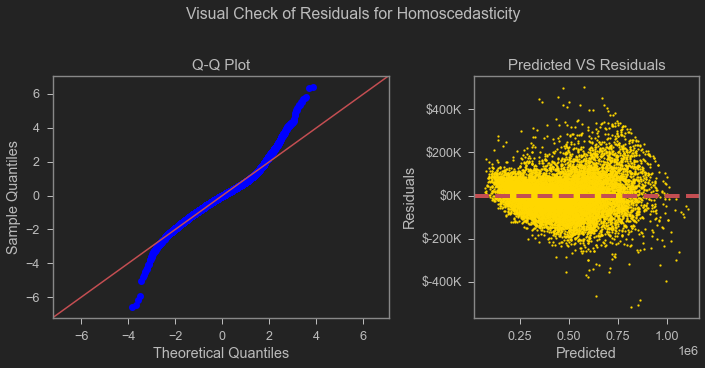

In [69]:
fin1 = OLS_sm(df=df_model_processed_ohe,numeric_features=features_selection.Feature.to_list(),show_summary=False)

In [122]:
len(features_selection.Feature.to_list())

95

In [70]:
check_for_high_p_val(fin1)

,features,p_values
0,Intercept,0.1249
1,sqft_lot15,0.0782
2,zipcode_98002,0.2901
3,zipcode_98003,0.9807
4,zipcode_98022,0.7584
5,zipcode_98030,0.4881
6,zipcode_98032,0.8967
7,zipcode_98042,0.0858
8,grade_4,0.1260
9,grade_5,0.0792


#### RFECV

In [71]:
df_RFECV = df_model_processed_ohe.copy()

In [72]:
X_RFECV = df_RFECV.drop(columns='price').copy()
y_RFECV = df_RFECV['price']

In [73]:
reg_RFECV = LinearRegression(n_jobs=-1)

In [74]:
from sklearn.feature_selection import RFECV

In [75]:
rfecv_selector = RFECV(
    reg_RFECV,
    step=1,
#     min_features_to_select=7,
    cv=10,
#     scoring='neg_mean_absolute_error',
    verbose=0,
    n_jobs=-1,
)

In [76]:
rfecv_selector.fit(X_RFECV,y_RFECV)
rfecv_selector.support_

array([False, False,  True, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [77]:
rfecv_selector.ranking_

array([79, 60,  1, 77, 69, 66, 41, 67,  6, 73, 85, 89,  1,  7, 16, 18, 22,
       56, 37, 51, 53, 87, 80, 47, 26, 39, 24, 86, 83, 88, 14, 31, 74,  1,
        1, 84, 49, 19, 20, 72, 50, 76, 54, 40, 68, 35, 25, 23, 32, 78,  2,
        8,  4, 48,  9, 52,  1,  1, 12, 13, 11, 33,  1, 10, 30, 29, 34, 17,
       21, 55, 63, 36, 57, 70, 28, 71, 75, 81,  5, 27, 65, 64, 62, 59, 58,
       38,  3, 45, 42, 43, 44, 46, 82, 61, 15])

In [78]:
rfecv_selector.grid_scores_

array([ 2.59283167e-01,  2.62492215e-01,  2.96286788e-01,  3.21587808e-01,
        3.45204899e-01,  3.53023871e-01,  3.67221848e-01, -1.31889719e+18,
       -4.91998975e+17, -1.97411921e+17, -7.02419553e+20, -1.38164718e+19,
       -5.51443359e+19, -1.52818990e+19, -2.54173023e+18, -1.17088956e+19,
       -5.48461909e+19, -5.75557991e+19, -3.79233182e+19, -6.97483365e+20,
       -9.55437776e+19, -2.73114832e+18, -5.99369738e+20, -4.39186228e+20,
       -2.44947455e+20, -2.74842965e+18, -1.09109652e+20, -3.30515170e+19,
       -8.78155724e+18, -1.77881514e+20, -1.30393242e+20, -3.30187303e+18,
       -1.33543450e+19, -4.86405407e+17, -1.38169894e+18, -2.07032766e+18,
       -6.80517236e+18, -4.64288961e+19, -1.94499959e+19, -2.10395734e+18,
       -6.65861693e+20, -2.57365473e+19, -9.63917879e+17, -3.86413774e+19,
       -1.90544074e+19, -5.67031141e+18, -2.71149452e+17, -2.11397109e+19,
       -3.16602405e+19, -5.28613319e+18, -4.40344479e+18, -1.33191709e+19,
       -8.25910897e+18, -

In [79]:
rfecv_selector.support_

array([False, False,  True, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

Optimal number of features : 7


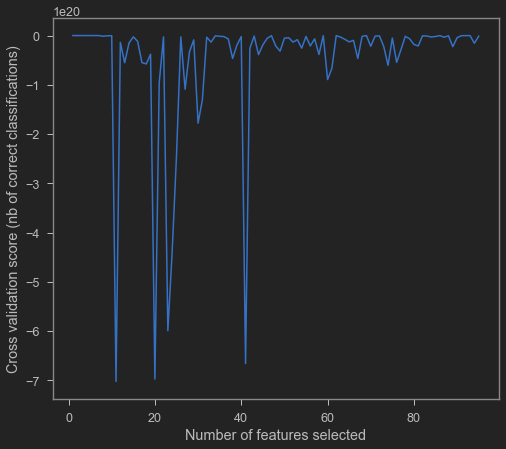

In [80]:
print("Optimal number of features : %d" % rfecv_selector.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1,
               len(rfecv_selector.grid_scores_) + 1),
         rfecv_selector.grid_scores_)
plt.show()

In [81]:
tem_=pd.DataFrame(rfecv_selector.ranking_,index=X_RFECV.columns)
tem_.reset_index(inplace=True)
tem_.columns = ['feature','rank']
tem_[tem_['rank']==1]

,feature,rank
2,sqft_living,1
12,zipcode_98004,1
33,zipcode_98039,1
34,zipcode_98040,1
56,zipcode_98109,1
57,zipcode_98112,1
62,zipcode_98119,1


In [128]:
tem_[tem_['rank']==1]['feature'].tolist()

['sqft_living',
 'zipcode_98004',
 'zipcode_98039',
 'zipcode_98040',
 'zipcode_98109',
 'zipcode_98112',
 'zipcode_98119']

Formula for the OLS model:  price ~ sqft_living + zipcode_98004 + zipcode_98039 + zipcode_98040 + zipcode_98109 + zipcode_98112 + zipcode_98119


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     1537.
Date:                Fri, 07 May 2021   Prob (F-statistic):               0.00
Time:                        03:23:55   Log-Likelihood:            -2.2649e+05
No. Observations:               16980   AIC:                         4.530e+05
Df Residuals:                   16972   BIC:                         4.531e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept          2e+05   2938.016     68.075      0.000    1.94e+05    2.06e+05
sqft_living    5.941e+05   6711.759     88.518      0.000    5.81e+05    6.07e+05
zipcode_98004  3.832e+05   1.32e+04     28.968      0.000    3.57e+05    4.09e+05
zipcode_98039  4.917e+05   6.72e+04      7.317      0.000     3.6e+05    6.23e+05
zipcode_98040  3.016e+05   1.33e+04     22.754      0.000    2.76e+05    3.28e+05
zipcode_98109  2.741e+05   1.62e+04     16.875      0.000    2.42e+05    3.06e+05
zipcode_98112  2.818e+05   1.18e+04     23.827      0.000    2.59e+05    3.05e+05
zipcode_98119  2.679e+05   1.23e+04     21.810      0.000    2.44e+05    2.92e+05
==============================================================================
Omnibus:                      729.691   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              825.767
Skew:                           0.534   Prob(JB):                    4.86e-180
Kurtosis:                       3.162   Cond. No.                         62.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

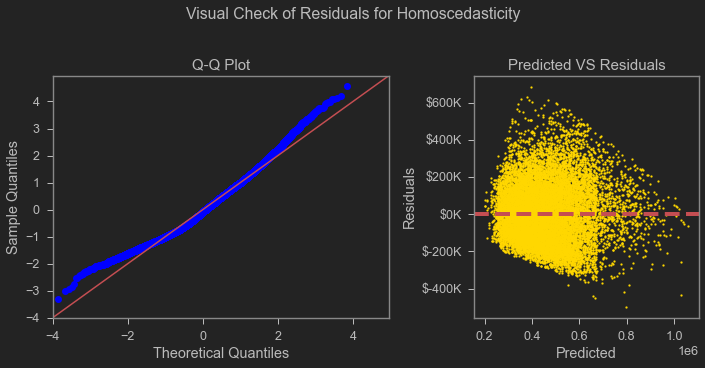

In [131]:
OLS_sm(df_model_processed_ohe,numeric_features=tem_[tem_['rank']==1]['feature'].tolist())

### Embedded Methods

#### Lasso

In [82]:
from sklearn.linear_model import LassoCV

In [95]:
df_Lasso_ = df_model_2.copy()
df_Lasso_= pd.get_dummies(df_Lasso_,
               columns=categorical_feat_model,
               sparse=False,
               drop_first=True)

In [96]:
scaler2 = MinMaxScaler()

In [97]:
min_max_scaled = scaler2.fit_transform(df_Lasso_)
df_Lasso = pd.DataFrame(min_max_scaled, columns=df_Lasso_.columns)

In [98]:
df_Lasso.describe().T

,count,mean,std,min,25%,50%,75%,max
price,16980.0,0.356443,0.184608,0.0,0.213941,0.322115,0.465012,1.0
bedrooms,16980.0,0.225424,0.084667,0.0,0.200000,0.200000,0.300000,1.0
bathrooms,16980.0,0.422438,0.190594,0.0,0.285714,0.428571,0.571429,1.0
sqft_living,16980.0,0.402000,0.172133,0.0,0.269444,0.383333,0.519444,1.0
sqft_lot,16980.0,0.373956,0.194372,0.0,0.239216,0.371768,0.485898,1.0
...,...,...,...,...,...,...,...,...
grade_7,16980.0,0.478916,0.499570,0.0,0.000000,0.000000,1.000000,1.0
grade_8,16980.0,0.293816,0.455522,0.0,0.000000,0.000000,1.000000,1.0
grade_9,16980.0,0.091166,0.287854,0.0,0.000000,0.000000,0.000000,1.0
grade_10,16980.0,0.016196,0.126231,0.0,0.000000,0.000000,0.000000,1.0


In [99]:
X_Lasso = df_Lasso.drop(columns='price').copy()
y_Lasso = df_Lasso['price']

In [100]:
reg_Lasso = LassoCV(cv=5, random_state=0).fit(X_Lasso, y_Lasso)

In [101]:
reg_Lasso.score(X_Lasso, y_Lasso)

0.8307881074614486

In [102]:
tem=pd.DataFrame(reg_Lasso.coef_,index=X_Lasso.columns)
tem.reset_index(inplace=True)
tem.columns = ['feature','coeff']
tem[tem['coeff']==0]

,feature,coeff
9,sqft_lot15,-0.0
44,zipcode_98070,-0.0
70,zipcode_98148,-0.0
91,grade_8,0.0


In [103]:
with pd.option_context("display.max_rows", None):
    print(tem.round(4))

          feature     coeff
0        bedrooms -0.017860
1       bathrooms  0.047381
2     sqft_living  0.397990
3        sqft_lot  0.016454
4          floors -0.024447
5   sqft_basement -0.040868
6        yr_built -0.059831
7    yr_renovated  0.033681
8   sqft_living15  0.122825
9      sqft_lot15 -0.000000
10  zipcode_98002 -0.041856
11  zipcode_98003 -0.049513
12  zipcode_98004  0.442144
13  zipcode_98005  0.254359
14  zipcode_98006  0.198513
15  zipcode_98007  0.181693
16  zipcode_98008  0.173181
17  zipcode_98010  0.017039
18  zipcode_98011  0.084176
19  zipcode_98014  0.040877
20  zipcode_98019  0.038909
21  zipcode_98022 -0.045340
22  zipcode_98023 -0.065412
23  zipcode_98024  0.050006
24  zipcode_98027  0.162348
25  zipcode_98028  0.073411
26  zipcode_98029  0.164597
27  zipcode_98030 -0.044512
28  zipcode_98031 -0.036052
29  zipcode_98032 -0.049635
30  zipcode_98033  0.243160
31  zipcode_98034  0.125405
32  zipcode_98038 -0.013410
33  zipcode_98039  0.468550
34  zipcode_98040  0

In [135]:
len(tem[tem['coeff']!=0]['feature'].tolist())

91

Formula for the OLS model:  price ~ bedrooms + bathrooms + sqft_living + sqft_lot + floors + sqft_basement + yr_built + yr_renovated + sqft_living15 + zipcode_98002 + zipcode_98003 + zipcode_98004 + zipcode_98005 + zipcode_98006 + zipcode_98007 + zipcode_98008 + zipcode_98010 + zipcode_98011 + zipcode_98014 + zipcode_98019 + zipcode_98022 + zipcode_98023 + zipcode_98024 + zipcode_98027 + zipcode_98028 + zipcode_98029 + zipcode_98030 + zipcode_98031 + zipcode_98032 + zipcode_98033 + zipcode_98034 + zipcode_98038 + zipcode_98039 + zipcode_98040 + zipcode_98042 + zipcode_98045 + zipcode_98052 + zipcode_98053 + zipcode_98055 + zipcode_98056 + zipcode_98058 + zipcode_98059 + zipcode_98065 + zipcode_98072 + zipcode_98074 + zipcode_98075 + zipcode_98077 + zipcode_98092 + zipcode_98102 + zipcode_98103 + zipcode_98105 + zipcode_98106 + zipcode_98107 + zipcode_98108 + zipcode_98109 + zipcode_98112 + zipcode_98115 + zipcode_98116 + zipcode_98117 + zipcode_98118 + zipcode_98119 + zipcode_98122 + z

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     920.1
Date:                Fri, 07 May 2021   Prob (F-statistic):               0.00
Time:                        03:40:42   Log-Likelihood:            -2.1551e+05
No. Observations:               16980   AIC:                         4.312e+05
Df Residuals:                   16888   BIC:                         4.319e+05
Df Model:                          91                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       7.56e+04   9645.544      7.838      0.000    5.67e+04    9.45e+04
bedrooms      -2.407e+04   9667.142     -2.490      0.013    -4.3e+04   -5121.542
bathrooms      5.179e+04   5561.687      9.312      0.000    4.09e+04    6.27e+04
sqft_living    4.208e+05   7990.879     52.659      0.000    4.05e+05    4.36e+05
sqft_lot       2.388e+04   4547.683      5.252      0.000     1.5e+04    3.28e+04
floors        -3.143e+04   4696.103     -6.692      0.000   -4.06e+04   -2.22e+04
sqft_basement -4.732e+04   3100.145    -15.265      0.000   -5.34e+04   -4.12e+04
yr_built      -5.591e+04   4242.105    -13.179      0.000   -6.42e+04   -4.76e+04
yr_renovated   3.587e+04   3831.831      9.360      0.000    2.84e+04    4.34e+04
sqft_living15  1.245e+05   8692.882     14.319      0.000    1.07e+05    1.42e+05
zipcode_98002 -2965.0852   7112.934     -0.417      0.677   -1.69e+04     1.1e+04
zipcode_98003 -1.082e+04   6469.207     -1.672      0.095   -2.35e+04    1862.820
zipcode_98004  5.069e+05   8142.302     62.256      0.000    4.91e+05    5.23e+05
zipcode_98005   3.12e+05   9093.817     34.309      0.000    2.94e+05     3.3e+05
zipcode_98006  2.513e+05   6318.575     39.776      0.000    2.39e+05    2.64e+05
zipcode_98007  2.362e+05   8381.412     28.178      0.000     2.2e+05    2.53e+05
zipcode_98008  2.253e+05   6639.560     33.931      0.000    2.12e+05    2.38e+05
zipcode_98010  6.972e+04   1.25e+04      5.576      0.000    4.52e+04    9.42e+04
zipcode_98011   1.33e+05   7456.730     17.840      0.000    1.18e+05    1.48e+05
zipcode_98014  9.451e+04   1.23e+04      7.678      0.000    7.04e+04    1.19e+05
zipcode_98019   8.56e+04   7919.712     10.808      0.000    7.01e+04    1.01e+05
zipcode_98022 -8192.8094   7772.715     -1.054      0.292   -2.34e+04    7042.525
zipcode_98023 -2.623e+04   5627.033     -4.661      0.000   -3.73e+04   -1.52e+04
zipcode_98024  1.135e+05   1.67e+04      6.804      0.000    8.08e+04    1.46e+05
zipcode_98027  2.152e+05   6813.064     31.587      0.000    2.02e+05    2.29e+05
zipcode_98028  1.209e+05   6602.548     18.312      0.000    1.08e+05    1.34e+05
zipcode_98029  2.171e+05   6411.174     33.862      0.000    2.05e+05     2.3e+05
zipcode_98030 -5853.4207   6634.354     -0.882      0.378   -1.89e+04    7150.607
zipcode_98031  3307.6914   6539.281      0.506      0.613   -9509.982    1.61e+04
zipcode_98032 -1.201e+04   8553.723     -1.404      0.160   -2.88e+04    4759.481
zipcode_98033  2.974e+05   6101.611     48.744      0.000    2.85e+05    3.09e+05
zipcode_98034  1.741e+05   5489.609     31.718      0.000    1.63e+05    1.85e+05
zipcode_98038  2.751e+04   5539.905      4.966      0.000    1.67e+04    3.84e+04
zipcode_98039  6.184e+05   3.55e+04     17.396      0.000    5.49e+05    6.88e+05
zipcode_98040  3.978e+05   8201.585     48.498   

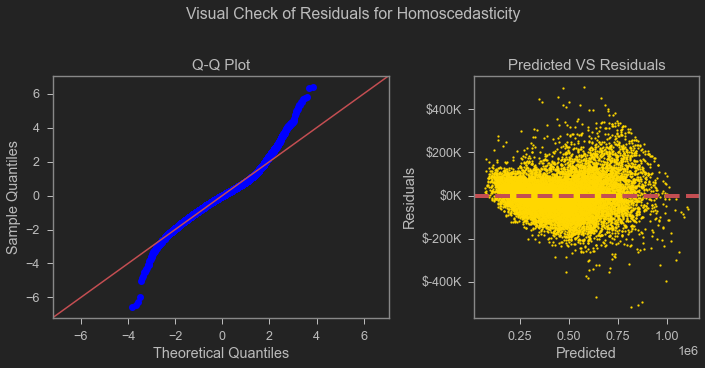

In [134]:
OLS_sm(df_model_processed_ohe,numeric_features=tem[tem['coeff']!=0]['feature'].tolist())

# another

In [104]:
from sklearn.svm import SVR

In [113]:
X = df_Lasso.drop(columns='price').copy()

y = df_Lasso['price'].copy()

estimator = SVR(kernel="linear")
selector = RFE(estimator) 
selector = selector.fit(X, y.values.ravel())

In [114]:
X_RFE = X[X.columns[selector.support_]]

lin_reg = LinearRegression()

lin_reg.fit(X_RFE, y)

y_pred = lin_reg.predict(X_RFE)

metrics.r2_score(y,y_pred)

0.776523847362918

In [115]:
print(f"""number of selected feature {X_RFE.shape[1]}""")

number of selected feature 47


In [120]:
X.columns[selector.support_].tolist()

['sqft_living',
 'sqft_living15',
 'zipcode_98004',
 'zipcode_98005',
 'zipcode_98006',
 'zipcode_98007',
 'zipcode_98008',
 'zipcode_98011',
 'zipcode_98014',
 'zipcode_98024',
 'zipcode_98027',
 'zipcode_98028',
 'zipcode_98029',
 'zipcode_98033',
 'zipcode_98034',
 'zipcode_98039',
 'zipcode_98040',
 'zipcode_98052',
 'zipcode_98053',
 'zipcode_98072',
 'zipcode_98074',
 'zipcode_98075',
 'zipcode_98077',
 'zipcode_98102',
 'zipcode_98103',
 'zipcode_98105',
 'zipcode_98106',
 'zipcode_98107',
 'zipcode_98109',
 'zipcode_98112',
 'zipcode_98115',
 'zipcode_98116',
 'zipcode_98117',
 'zipcode_98118',
 'zipcode_98119',
 'zipcode_98122',
 'zipcode_98125',
 'zipcode_98126',
 'zipcode_98133',
 'zipcode_98136',
 'zipcode_98144',
 'zipcode_98155',
 'zipcode_98177',
 'zipcode_98199',
 'waterfront_1',
 'view_4',
 'grade_11']

Formula for the OLS model:  price ~ sqft_living + sqft_living15 + zipcode_98004 + zipcode_98005 + zipcode_98006 + zipcode_98007 + zipcode_98008 + zipcode_98011 + zipcode_98014 + zipcode_98024 + zipcode_98027 + zipcode_98028 + zipcode_98029 + zipcode_98033 + zipcode_98034 + zipcode_98039 + zipcode_98040 + zipcode_98052 + zipcode_98053 + zipcode_98072 + zipcode_98074 + zipcode_98075 + zipcode_98077 + zipcode_98102 + zipcode_98103 + zipcode_98105 + zipcode_98106 + zipcode_98107 + zipcode_98109 + zipcode_98112 + zipcode_98115 + zipcode_98116 + zipcode_98117 + zipcode_98118 + zipcode_98119 + zipcode_98122 + zipcode_98125 + zipcode_98126 + zipcode_98133 + zipcode_98136 + zipcode_98144 + zipcode_98155 + zipcode_98177 + zipcode_98199 + waterfront_1 + view_4 + grade_11


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     1252.
Date:                Fri, 07 May 2021   Prob (F-statistic):               0.00
Time:                        03:42:28   Log-Likelihood:            -2.1794e+05
No. Observations:               16980   AIC:                         4.360e+05
Df Residuals:                   16932   BIC:                         4.363e+05
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       3.99e+04   2412.802     16.537      0.000    3.52e+04    4.46e+04
sqft_living    4.833e+05   5711.153     84.632      0.000    4.72e+05    4.95e+05
sqft_living15  2.536e+05   9099.727     27.869      0.000    2.36e+05    2.71e+05
zipcode_98004  4.893e+05   8090.384     60.479      0.000    4.73e+05    5.05e+05
zipcode_98005  3.077e+05   9319.159     33.022      0.000    2.89e+05    3.26e+05
zipcode_98006  2.491e+05   5494.654     45.330      0.000    2.38e+05     2.6e+05
zipcode_98007  2.263e+05   8413.942     26.892      0.000     2.1e+05    2.43e+05
zipcode_98008  2.101e+05   6012.542     34.949      0.000    1.98e+05    2.22e+05
zipcode_98011  9.864e+04   7222.837     13.657      0.000    8.45e+04    1.13e+05
zipcode_98014  6.291e+04   1.33e+04      4.724      0.000    3.68e+04     8.9e+04
zipcode_98024    9.7e+04   1.86e+04      5.215      0.000    6.05e+04    1.33e+05
zipcode_98027  1.866e+05   6241.825     29.888      0.000    1.74e+05    1.99e+05
zipcode_98028  8.886e+04   6023.684     14.752      0.000    7.71e+04    1.01e+05
zipcode_98029  2.008e+05   5581.352     35.981      0.000     1.9e+05    2.12e+05
zipcode_98033   2.84e+05   5248.163     54.110      0.000    2.74e+05    2.94e+05
zipcode_98034  1.432e+05   4284.561     33.423      0.000    1.35e+05    1.52e+05
zipcode_98039  5.915e+05   4.07e+04     14.541      0.000    5.12e+05    6.71e+05
zipcode_98040  4.041e+05   8120.955     49.762      0.000    3.88e+05     4.2e+05
zipcode_98052  2.192e+05   4436.202     49.423      0.000    2.11e+05    2.28e+05
zipcode_98053  2.119e+05   6574.686     32.235      0.000    1.99e+05    2.25e+05
zipcode_98072   1.08e+05   7795.680     13.857      0.000    9.27e+04    1.23e+05
zipcode_98074  1.858e+05   5459.212     34.033      0.000    1.75e+05    1.96e+05
zipcode_98075  2.036e+05   7405.507     27.492      0.000    1.89e+05    2.18e+05
zipcode_98077   1.34e+05   1.61e+04      8.302      0.000    1.02e+05    1.66e+05
zipcode_98102  3.911e+05   9810.444     39.865      0.000    3.72e+05     4.1e+05
zipcode_98103  3.004e+05   3985.601     75.373      0.000    2.93e+05    3.08e+05
zipcode_98105   3.54e+05   6925.636     51.108      0.000     3.4e+05    3.68e+05
zipcode_98106  7.913e+04   5238.708     15.104      0.000    6.89e+04    8.94e+04
zipcode_98107  2.999e+05   5801.237     51.703      0.000    2.89e+05    3.11e+05
zipcode_98109  3.994e+05   9867.843     40.470      0.000     3.8e+05    4.19e+05
zipcode_98112   4.09e+05   7208.950     56.739      0.000    3.95e+05    4.23e+05
zipcode_98115  2.881e+05   4096.168     70.324      0.000     2.8e+05    2.96e+05
zipcode_98116  2.795e+05   5405.543     51.712      0.000    2.69e+05     2.9e+05
zipcode_98117  2.898e+05   4154.883     69.740      0.000    2.82e+05    2.98e+05
zipcode_98118  1.214e+05   4353.348     27.885   

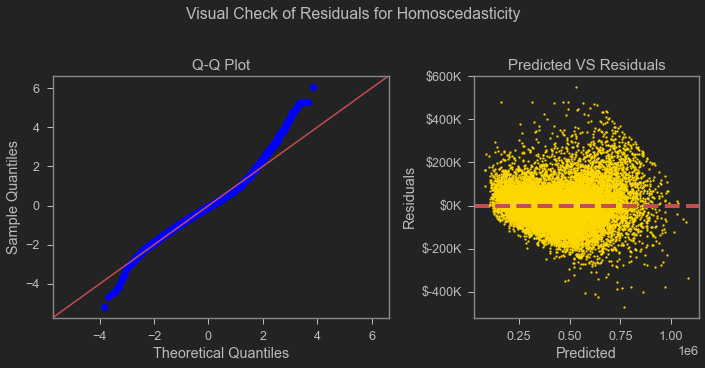

In [136]:
OLS_sm(df_model_processed_ohe,numeric_features=X.columns[selector.support_].tolist())